In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r''  # Insert path of the cpc model
dataset_path = r''  # Insert path of the test dataset that was created using the run_cpc.py script

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_256/models/epoch_45.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(2, 30))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/28 [00:00<?, ?it/s]

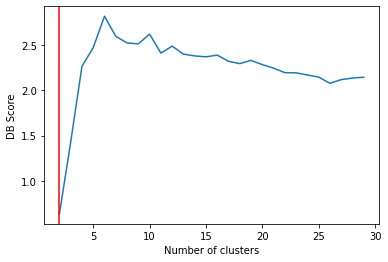

{0, 1}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

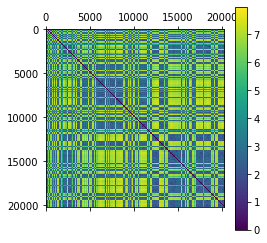

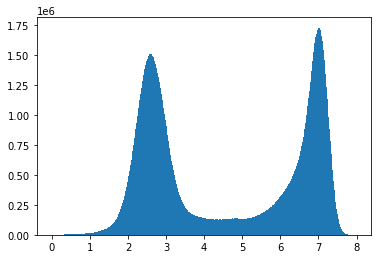

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

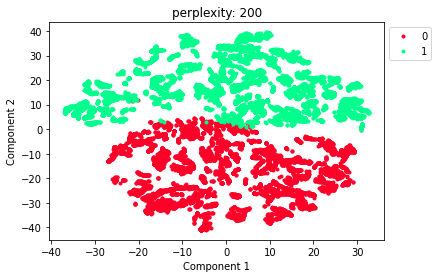

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 12

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9982259892573794


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.052647413973380824
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.7417127071823204
layer 3: 0.7417127071823204
layer 4: 0.6799033149171271
layer 5: 0.587189226519337
layer 6: 0.4017610497237569
layer 7: 0.23951139502762434
layer 8: 0.13134495856353592
layer 9: 0.06374093577348067
layer 10: 0.028007380870165747
Epoch: 00 | Batch: 000 / 011 | Total loss: 0.704 | Reg loss: 0.020 | Tree loss: 0.704 | Accuracy: 0.565000 | 21.07 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 0.702 | Reg loss: 0.019 | Tree loss: 0.702 | Accuracy: 0.489000 | 18.94 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 0.698 | Reg loss: 0.018 | Tree loss: 0.698 | Accuracy: 0.531000 | 18.184 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 0.693 | Reg loss: 0.018 | Tree loss: 0.693 | Accuracy: 0.547500 | 17.82 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 0.693 | Reg loss: 0.017 | Tree loss: 0.693 | Accuracy: 0.546000 | 17.595 sec/iter
Epoch: 00 | Batch: 005 / 0

Epoch: 04 | Batch: 008 / 011 | Total loss: 0.689 | Reg loss: 0.012 | Tree loss: 0.689 | Accuracy: 0.562500 | 15.109 sec/iter
Epoch: 04 | Batch: 009 / 011 | Total loss: 0.690 | Reg loss: 0.012 | Tree loss: 0.690 | Accuracy: 0.563500 | 15.109 sec/iter
Epoch: 04 | Batch: 010 / 011 | Total loss: 0.695 | Reg loss: 0.012 | Tree loss: 0.695 | Accuracy: 0.556314 | 14.904 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 0.699 | Reg loss: 0.012 | Tree loss: 0.699 | Accuracy: 0.655500 | 15.03 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 0.697 | Reg loss: 0.012 | Tree loss: 0.697 | Accuracy: 0.657500 | 15.027 sec/iter
Epoch: 05 | Batch: 002 / 011

Epoch: 09 | Batch: 005 / 011 | Total loss: 0.694 | Reg loss: 0.011 | Tree loss: 0.694 | Accuracy: 0.611500 | 14.557 sec/iter
Epoch: 09 | Batch: 006 / 011 | Total loss: 0.692 | Reg loss: 0.011 | Tree loss: 0.692 | Accuracy: 0.601500 | 14.558 sec/iter
Epoch: 09 | Batch: 007 / 011 | Total loss: 0.694 | Reg loss: 0.011 | Tree loss: 0.694 | Accuracy: 0.570000 | 14.559 sec/iter
Epoch: 09 | Batch: 008 / 011 | Total loss: 0.692 | Reg loss: 0.011 | Tree loss: 0.692 | Accuracy: 0.574000 | 14.506 sec/iter
Epoch: 09 | Batch: 009 / 011 | Total loss: 0.692 | Reg loss: 0.011 | Tree loss: 0.692 | Accuracy: 0.574500 | 14.511 sec/iter
Epoch: 09 | Batch: 010 / 011 | Total loss: 0.684 | Reg loss: 0.011 | Tree loss: 0.684 | Accuracy: 0.607509 | 14.414 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 14 | Batch: 002 / 011 | Total loss: 0.698 | Reg loss: 0.010 | Tree loss: 0.698 | Accuracy: 0.719000 | 14.331 sec/iter
Epoch: 14 | Batch: 003 / 011 | Total loss: 0.696 | Reg loss: 0.010 | Tree loss: 0.696 | Accuracy: 0.703000 | 14.334 sec/iter
Epoch: 14 | Batch: 004 / 011 | Total loss: 0.694 | Reg loss: 0.010 | Tree loss: 0.694 | Accuracy: 0.675000 | 14.337 sec/iter
Epoch: 14 | Batch: 005 / 011 | Total loss: 0.695 | Reg loss: 0.011 | Tree loss: 0.695 | Accuracy: 0.598000 | 14.34 sec/iter
Epoch: 14 | Batch: 006 / 011 | Total loss: 0.692 | Reg loss: 0.011 | Tree loss: 0.692 | Accuracy: 0.583500 | 14.342 sec/iter
Epoch: 14 | Batch: 007 / 011 | Total loss: 0.689 | Reg loss: 0.011 | Tree loss: 0.689 | Accuracy: 0.585000 | 14.344 sec/iter
Epoch: 14 | Batch: 008 / 011 | Total loss: 0.692 | Reg loss: 0.011 | Tree loss: 0.692 | Accuracy: 0.563000 | 14.31 sec/iter
Epoch: 14 | Batch: 009 / 011 | Total loss: 0.689 | Reg loss: 0.011 | Tree loss: 0.689 | Accuracy: 0.572500 | 14.315 sec/iter
Ep

Epoch: 19 | Batch: 000 / 011 | Total loss: 0.695 | Reg loss: 0.011 | Tree loss: 0.695 | Accuracy: 0.689500 | 14.219 sec/iter
Epoch: 19 | Batch: 001 / 011 | Total loss: 0.695 | Reg loss: 0.011 | Tree loss: 0.695 | Accuracy: 0.684000 | 14.222 sec/iter
Epoch: 19 | Batch: 002 / 011 | Total loss: 0.692 | Reg loss: 0.011 | Tree loss: 0.692 | Accuracy: 0.688500 | 14.225 sec/iter
Epoch: 19 | Batch: 003 / 011 | Total loss: 0.689 | Reg loss: 0.011 | Tree loss: 0.689 | Accuracy: 0.680500 | 14.228 sec/iter
Epoch: 19 | Batch: 004 / 011 | Total loss: 0.681 | Reg loss: 0.011 | Tree loss: 0.681 | Accuracy: 0.649500 | 14.23 sec/iter
Epoch: 19 | Batch: 005 / 011 | Total loss: 0.675 | Reg loss: 0.011 | Tree loss: 0.675 | Accuracy: 0.584500 | 14.233 sec/iter
Epoch: 19 | Batch: 006 / 011 | Total loss: 0.677 | Reg loss: 0.011 | Tree loss: 0.677 | Accuracy: 0.552500 | 14.235 sec/iter
Epoch: 19 | Batch: 007 / 011 | Total loss: 0.671 | Reg loss: 0.011 | Tree loss: 0.671 | Accuracy: 0.563000 | 14.237 sec/iter
E

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 24 | Batch: 000 / 011 | Total loss: 0.682 | Reg loss: 0.011 | Tree loss: 0.682 | Accuracy: 0.616000 | 14.158 sec/iter
Epoch: 24 | Batch: 001 / 011 | Total loss: 0.674 | Reg loss: 0.011 | Tree loss: 0.674 | Accuracy: 0.637500 | 14.161 sec/iter
Epoch: 24 | Batch: 002 / 011 | Total loss: 0.672 | Reg loss: 0.011 | Tree loss: 0.672 | Accuracy: 0.604500 | 14.164 sec/iter
Epoch: 24 | Batch: 003 / 011 | Total loss: 0.675 | Reg loss: 0.011 | Tree loss: 0.675 | Accuracy: 0.539000 | 14.166 sec/iter
Epoch: 24 | Batch: 004 / 011 | Total loss: 0.671 | Reg loss: 0.011 | Tree loss: 0.671 | Accuracy: 0.548000 | 14.168 sec/iter
Epoch: 24 | Batch: 005 / 01

Epoch: 28 | Batch: 008 / 011 | Total loss: 0.637 | Reg loss: 0.012 | Tree loss: 0.637 | Accuracy: 0.698500 | 14.121 sec/iter
Epoch: 28 | Batch: 009 / 011 | Total loss: 0.638 | Reg loss: 0.012 | Tree loss: 0.638 | Accuracy: 0.700500 | 14.124 sec/iter
Epoch: 28 | Batch: 010 / 011 | Total loss: 0.645 | Reg loss: 0.013 | Tree loss: 0.645 | Accuracy: 0.689420 | 14.092 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 29 | Batch: 000 / 011 | Total loss: 0.664 | Reg loss: 0.012 | Tree loss: 0.664 | Accuracy: 0.656500 | 14.117 sec/iter
Epoch: 29 | Batch: 001 / 011 | Total loss: 0.661 | Reg loss: 0.012 | Tree loss: 0.661 | Accuracy: 0.623500 | 14.119 sec/iter
Epoch: 29 | Batch: 002 / 01

Epoch: 33 | Batch: 005 / 011 | Total loss: 0.590 | Reg loss: 0.013 | Tree loss: 0.590 | Accuracy: 0.707500 | 14.103 sec/iter
Epoch: 33 | Batch: 006 / 011 | Total loss: 0.593 | Reg loss: 0.013 | Tree loss: 0.593 | Accuracy: 0.711000 | 14.105 sec/iter
Epoch: 33 | Batch: 007 / 011 | Total loss: 0.583 | Reg loss: 0.013 | Tree loss: 0.583 | Accuracy: 0.756000 | 14.106 sec/iter
Epoch: 33 | Batch: 008 / 011 | Total loss: 0.578 | Reg loss: 0.013 | Tree loss: 0.578 | Accuracy: 0.783000 | 14.092 sec/iter
Epoch: 33 | Batch: 009 / 011 | Total loss: 0.569 | Reg loss: 0.013 | Tree loss: 0.569 | Accuracy: 0.782500 | 14.095 sec/iter
Epoch: 33 | Batch: 010 / 011 | Total loss: 0.562 | Reg loss: 0.014 | Tree loss: 0.562 | Accuracy: 0.754266 | 14.067 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 38 | Batch: 002 / 011 | Total loss: 0.585 | Reg loss: 0.014 | Tree loss: 0.585 | Accuracy: 0.724000 | 14.074 sec/iter
Epoch: 38 | Batch: 003 / 011 | Total loss: 0.559 | Reg loss: 0.014 | Tree loss: 0.559 | Accuracy: 0.735500 | 14.076 sec/iter
Epoch: 38 | Batch: 004 / 011 | Total loss: 0.587 | Reg loss: 0.014 | Tree loss: 0.587 | Accuracy: 0.674000 | 14.078 sec/iter
Epoch: 38 | Batch: 005 / 011 | Total loss: 0.562 | Reg loss: 0.014 | Tree loss: 0.562 | Accuracy: 0.708500 | 14.08 sec/iter
Epoch: 38 | Batch: 006 / 011 | Total loss: 0.532 | Reg loss: 0.014 | Tree loss: 0.532 | Accuracy: 0.802000 | 14.081 sec/iter
Epoch: 38 | Batch: 007 / 011 | Total loss: 0.543 | Reg loss: 0.014 | Tree loss: 0.543 | Accuracy: 0.823000 | 14.083 sec/iter
Epoch: 38 | Batch: 008 / 011 | Total loss: 0.538 | Reg loss: 0.014 | Tree loss: 0.538 | Accuracy: 0.820500 | 14.07 sec/iter
Epoch: 38 | Batch: 009 / 011 | Total loss: 0.534 | Reg loss: 0.014 | Tree loss: 0.534 | Accuracy: 0.848500 | 14.073 sec/iter
Ep

Epoch: 43 | Batch: 000 / 011 | Total loss: 0.591 | Reg loss: 0.014 | Tree loss: 0.591 | Accuracy: 0.694500 | 14.054 sec/iter
Epoch: 43 | Batch: 001 / 011 | Total loss: 0.583 | Reg loss: 0.014 | Tree loss: 0.583 | Accuracy: 0.694500 | 14.056 sec/iter
Epoch: 43 | Batch: 002 / 011 | Total loss: 0.555 | Reg loss: 0.014 | Tree loss: 0.555 | Accuracy: 0.735500 | 14.058 sec/iter
Epoch: 43 | Batch: 003 / 011 | Total loss: 0.547 | Reg loss: 0.014 | Tree loss: 0.547 | Accuracy: 0.729000 | 14.059 sec/iter
Epoch: 43 | Batch: 004 / 011 | Total loss: 0.560 | Reg loss: 0.014 | Tree loss: 0.560 | Accuracy: 0.687500 | 14.061 sec/iter
Epoch: 43 | Batch: 005 / 011 | Total loss: 0.531 | Reg loss: 0.014 | Tree loss: 0.531 | Accuracy: 0.735000 | 14.062 sec/iter
Epoch: 43 | Batch: 006 / 011 | Total loss: 0.517 | Reg loss: 0.014 | Tree loss: 0.517 | Accuracy: 0.783500 | 14.064 sec/iter
Epoch: 43 | Batch: 007 / 011 | Total loss: 0.512 | Reg loss: 0.014 | Tree loss: 0.512 | Accuracy: 0.825000 | 14.065 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 48 | Batch: 000 / 011 | Total loss: 0.593 | Reg loss: 0.014 | Tree loss: 0.593 | Accuracy: 0.696000 | 14.042 sec/iter
Epoch: 48 | Batch: 001 / 011 | Total loss: 0.567 | Reg loss: 0.014 | Tree loss: 0.567 | Accuracy: 0.704000 | 14.044 sec/iter
Epoch: 48 | Batch: 002 / 011 | Total loss: 0.534 | Reg loss: 0.014 | Tree loss: 0.534 | Accuracy: 0.743000 | 14.045 sec/iter
Epoch: 48 | Batch: 003 / 011 | Total loss: 0.519 | Reg loss: 0.014 | Tree loss: 0.519 | Accuracy: 0.740000 | 14.047 sec/iter
Epoch: 48 | Batch: 004 / 011 | Total loss: 0.528 | Reg loss: 0.014 | Tree loss: 0.528 | Accuracy: 0.736000 | 14.049 sec/iter
Epoch: 48 | Batch: 005 / 01

Epoch: 52 | Batch: 008 / 011 | Total loss: 0.482 | Reg loss: 0.014 | Tree loss: 0.482 | Accuracy: 0.799000 | 14.089 sec/iter
Epoch: 52 | Batch: 009 / 011 | Total loss: 0.475 | Reg loss: 0.014 | Tree loss: 0.475 | Accuracy: 0.846000 | 14.091 sec/iter
Epoch: 52 | Batch: 010 / 011 | Total loss: 0.485 | Reg loss: 0.014 | Tree loss: 0.485 | Accuracy: 0.846416 | 14.074 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 53 | Batch: 000 / 011 | Total loss: 0.581 | Reg loss: 0.014 | Tree loss: 0.581 | Accuracy: 0.697000 | 14.095 sec/iter
Epoch: 53 | Batch: 001 / 011 | Total loss: 0.555 | Reg loss: 0.014 | Tree loss: 0.555 | Accuracy: 0.715500 | 14.098 sec/iter
Epoch: 53 | Batch: 002 / 01

Epoch: 57 | Batch: 005 / 011 | Total loss: 0.498 | Reg loss: 0.015 | Tree loss: 0.498 | Accuracy: 0.788000 | 14.138 sec/iter
Epoch: 57 | Batch: 006 / 011 | Total loss: 0.501 | Reg loss: 0.015 | Tree loss: 0.501 | Accuracy: 0.764500 | 14.141 sec/iter
Epoch: 57 | Batch: 007 / 011 | Total loss: 0.516 | Reg loss: 0.015 | Tree loss: 0.516 | Accuracy: 0.764500 | 14.135 sec/iter
Epoch: 57 | Batch: 008 / 011 | Total loss: 0.482 | Reg loss: 0.015 | Tree loss: 0.482 | Accuracy: 0.785000 | 14.126 sec/iter
Epoch: 57 | Batch: 009 / 011 | Total loss: 0.487 | Reg loss: 0.015 | Tree loss: 0.487 | Accuracy: 0.812500 | 14.128 sec/iter
Epoch: 57 | Batch: 010 / 011 | Total loss: 0.461 | Reg loss: 0.015 | Tree loss: 0.461 | Accuracy: 0.819113 | 14.113 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 62 | Batch: 002 / 011 | Total loss: 0.534 | Reg loss: 0.015 | Tree loss: 0.534 | Accuracy: 0.731000 | 14.17 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 0.501 | Reg loss: 0.015 | Tree loss: 0.501 | Accuracy: 0.770000 | 14.172 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 0.471 | Reg loss: 0.015 | Tree loss: 0.471 | Accuracy: 0.812500 | 14.175 sec/iter
Epoch: 62 | Batch: 005 / 011 | Total loss: 0.468 | Reg loss: 0.015 | Tree loss: 0.468 | Accuracy: 0.810000 | 14.177 sec/iter
Epoch: 62 | Batch: 006 / 011 | Total loss: 0.484 | Reg loss: 0.015 | Tree loss: 0.484 | Accuracy: 0.797000 | 14.179 sec/iter
Epoch: 62 | Batch: 007 / 011 | Total loss: 0.465 | Reg loss: 0.015 | Tree loss: 0.465 | Accuracy: 0.797500 | 14.172 sec/iter
Epoch: 62 | Batch: 008 / 011 | Total loss: 0.488 | Reg loss: 0.015 | Tree loss: 0.488 | Accuracy: 0.773000 | 14.165 sec/iter
Epoch: 62 | Batch: 009 / 011 | Total loss: 0.488 | Reg loss: 0.015 | Tree loss: 0.488 | Accuracy: 0.755500 | 14.166 sec/iter
E

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 67 | Batch: 000 / 011 | Total loss: 0.536 | Reg loss: 0.015 | Tree loss: 0.536 | Accuracy: 0.733500 | 14.199 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 0.561 | Reg loss: 0.015 | Tree loss: 0.561 | Accuracy: 0.732000 | 14.201 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 0.540 | Reg loss: 0.015 | Tree loss: 0.540 | Accuracy: 0.744000 | 14.203 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 0.503 | Reg loss: 0.015 | Tree loss: 0.503 | Accuracy: 0.760000 | 14.205 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 0.469 | Reg loss: 0.015 | Tree loss: 0.469 | Accuracy: 0.787500 | 14.207 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 0.459 | Reg loss: 0.015 | Tree loss: 0.459 | Accuracy: 0.816000 | 14.209 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 0.482 | Reg loss: 0.015 | Tree loss: 0.482 | Accuracy: 0.792000 | 

Epoch: 71 | Batch: 010 / 011 | Total loss: 0.437 | Reg loss: 0.015 | Tree loss: 0.437 | Accuracy: 0.808874 | 14.212 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 72 | Batch: 000 / 011 | Total loss: 0.542 | Reg loss: 0.015 | Tree loss: 0.542 | Accuracy: 0.721000 | 14.231 sec/iter
Epoch: 72 | Batch: 001 / 011 | Total loss: 0.529 | Reg loss: 0.015 | Tree loss: 0.529 | Accuracy: 0.730000 | 14.232 sec/iter
Epoch: 72 | Batch: 002 / 011 | Total loss: 0.535 | Reg loss: 0.015 | Tree loss: 0.535 | Accuracy: 0.720000 | 14.234 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 0.484 | Reg loss: 0.015 | Tree loss: 0.484 | Accuracy: 0.774500 | 14.236 sec/iter
Epoch: 72 | Batch: 004 / 01

Epoch: 76 | Batch: 007 / 011 | Total loss: 0.455 | Reg loss: 0.015 | Tree loss: 0.455 | Accuracy: 0.802000 | 14.257 sec/iter
Epoch: 76 | Batch: 008 / 011 | Total loss: 0.460 | Reg loss: 0.015 | Tree loss: 0.460 | Accuracy: 0.794000 | 14.25 sec/iter
Epoch: 76 | Batch: 009 / 011 | Total loss: 0.451 | Reg loss: 0.015 | Tree loss: 0.451 | Accuracy: 0.799000 | 14.251 sec/iter
Epoch: 76 | Batch: 010 / 011 | Total loss: 0.452 | Reg loss: 0.015 | Tree loss: 0.452 | Accuracy: 0.781570 | 14.24 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 77 | Batch: 000 / 011 | Total loss: 0.537 | Reg loss: 0.015 | Tree loss: 0.537 | Accuracy: 0.725000 | 14.257 sec/iter
Epoch: 77 | Batch: 001 / 011 

Epoch: 81 | Batch: 004 / 011 | Total loss: 0.451 | Reg loss: 0.015 | Tree loss: 0.451 | Accuracy: 0.807500 | 14.286 sec/iter
Epoch: 81 | Batch: 005 / 011 | Total loss: 0.452 | Reg loss: 0.015 | Tree loss: 0.452 | Accuracy: 0.810500 | 14.288 sec/iter
Epoch: 81 | Batch: 006 / 011 | Total loss: 0.468 | Reg loss: 0.015 | Tree loss: 0.468 | Accuracy: 0.788000 | 14.289 sec/iter
Epoch: 81 | Batch: 007 / 011 | Total loss: 0.449 | Reg loss: 0.015 | Tree loss: 0.449 | Accuracy: 0.816500 | 14.285 sec/iter
Epoch: 81 | Batch: 008 / 011 | Total loss: 0.462 | Reg loss: 0.015 | Tree loss: 0.462 | Accuracy: 0.787500 | 14.279 sec/iter
Epoch: 81 | Batch: 009 / 011 | Total loss: 0.432 | Reg loss: 0.015 | Tree loss: 0.432 | Accuracy: 0.817000 | 14.28 sec/iter
Epoch: 81 | Batch: 010 / 011 | Total loss: 0.410 | Reg loss: 0.016 | Tree loss: 0.410 | Accuracy: 0.883959 | 14.269 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
lay

Epoch: 86 | Batch: 001 / 011 | Total loss: 0.503 | Reg loss: 0.016 | Tree loss: 0.503 | Accuracy: 0.750000 | 14.303 sec/iter
Epoch: 86 | Batch: 002 / 011 | Total loss: 0.482 | Reg loss: 0.016 | Tree loss: 0.482 | Accuracy: 0.751000 | 14.304 sec/iter
Epoch: 86 | Batch: 003 / 011 | Total loss: 0.487 | Reg loss: 0.016 | Tree loss: 0.487 | Accuracy: 0.768500 | 14.306 sec/iter
Epoch: 86 | Batch: 004 / 011 | Total loss: 0.467 | Reg loss: 0.016 | Tree loss: 0.467 | Accuracy: 0.794000 | 14.307 sec/iter
Epoch: 86 | Batch: 005 / 011 | Total loss: 0.445 | Reg loss: 0.016 | Tree loss: 0.445 | Accuracy: 0.823500 | 14.309 sec/iter
Epoch: 86 | Batch: 006 / 011 | Total loss: 0.444 | Reg loss: 0.016 | Tree loss: 0.444 | Accuracy: 0.812000 | 14.31 sec/iter
Epoch: 86 | Batch: 007 / 011 | Total loss: 0.454 | Reg loss: 0.016 | Tree loss: 0.454 | Accuracy: 0.807500 | 14.305 sec/iter
Epoch: 86 | Batch: 008 / 011 | Total loss: 0.461 | Reg loss: 0.016 | Tree loss: 0.461 | Accuracy: 0.793000 | 14.3 sec/iter
Epo

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 91 | Batch: 000 / 011 | Total loss: 0.502 | Reg loss: 0.016 | Tree loss: 0.502 | Accuracy: 0.743000 | 14.319 sec/iter
Epoch: 91 | Batch: 001 / 011 | Total loss: 0.509 | Reg loss: 0.016 | Tree loss: 0.509 | Accuracy: 0.754000 | 14.321 sec/iter
Epoch: 91 | Batch: 002 / 011 | Total loss: 0.491 | Reg loss: 0.016 | Tree loss: 0.491 | Accuracy: 0.764500 | 14.322 sec/iter
Epoch: 91 | Batch: 003 / 011 | Total loss: 0.471 | Reg loss: 0.016 | Tree loss: 0.471 | Accuracy: 0.778500 | 14.323 sec/iter
Epoch: 91 | Batch: 004 / 011 | Total loss: 0.456 | Reg loss: 0.016 | Tree loss: 0.456 | Accuracy: 0.804000 | 14.324 sec/iter
Epoch: 91 | Batch: 005 / 011 | Total loss: 0.445 | Reg loss: 0.016 | Tree loss: 0.445 | Accuracy: 0.819000 | 14.326 sec/iter
Epoch: 91 | Batch: 006 / 011 | Total loss: 0.441 | Reg loss: 0.016 | Tree loss: 0.441 | Accuracy: 0.822500 | 

Epoch: 95 | Batch: 010 / 011 | Total loss: 0.422 | Reg loss: 0.016 | Tree loss: 0.422 | Accuracy: 0.819113 | 14.32 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 96 | Batch: 000 / 011 | Total loss: 0.513 | Reg loss: 0.016 | Tree loss: 0.513 | Accuracy: 0.738000 | 14.334 sec/iter
Epoch: 96 | Batch: 001 / 011 | Total loss: 0.516 | Reg loss: 0.016 | Tree loss: 0.516 | Accuracy: 0.737000 | 14.335 sec/iter
Epoch: 96 | Batch: 002 / 011 | Total loss: 0.497 | Reg loss: 0.016 | Tree loss: 0.497 | Accuracy: 0.744000 | 14.336 sec/iter
Epoch: 96 | Batch: 003 / 011 | Total loss: 0.469 | Reg loss: 0.016 | Tree loss: 0.469 | Accuracy: 0.779500 | 14.337 sec/iter
Epoch: 96 | Batch: 004 / 011

Epoch: 100 | Batch: 007 / 011 | Total loss: 0.461 | Reg loss: 0.016 | Tree loss: 0.461 | Accuracy: 0.795500 | 14.349 sec/iter
Epoch: 100 | Batch: 008 / 011 | Total loss: 0.452 | Reg loss: 0.016 | Tree loss: 0.452 | Accuracy: 0.796500 | 14.345 sec/iter
Epoch: 100 | Batch: 009 / 011 | Total loss: 0.442 | Reg loss: 0.016 | Tree loss: 0.442 | Accuracy: 0.794500 | 14.345 sec/iter
Epoch: 100 | Batch: 010 / 011 | Total loss: 0.421 | Reg loss: 0.016 | Tree loss: 0.421 | Accuracy: 0.822526 | 14.336 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 101 | Batch: 000 / 011 | Total loss: 0.505 | Reg loss: 0.016 | Tree loss: 0.505 | Accuracy: 0.740500 | 14.348 sec/iter
Epoch: 101 | Batch: 00

Epoch: 105 | Batch: 004 / 011 | Total loss: 0.438 | Reg loss: 0.016 | Tree loss: 0.438 | Accuracy: 0.822500 | 14.364 sec/iter
Epoch: 105 | Batch: 005 / 011 | Total loss: 0.430 | Reg loss: 0.016 | Tree loss: 0.430 | Accuracy: 0.830000 | 14.365 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 0.426 | Reg loss: 0.016 | Tree loss: 0.426 | Accuracy: 0.826500 | 14.366 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 0.433 | Reg loss: 0.016 | Tree loss: 0.433 | Accuracy: 0.812500 | 14.362 sec/iter
Epoch: 105 | Batch: 008 / 011 | Total loss: 0.459 | Reg loss: 0.016 | Tree loss: 0.459 | Accuracy: 0.794500 | 14.357 sec/iter
Epoch: 105 | Batch: 009 / 011 | Total loss: 0.440 | Reg loss: 0.016 | Tree loss: 0.440 | Accuracy: 0.795000 | 14.358 sec/iter
Epoch: 105 | Batch: 010 / 011 | Total loss: 0.430 | Reg loss: 0.016 | Tree loss: 0.430 | Accuracy: 0.832765 | 14.349 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 110 | Batch: 001 / 011 | Total loss: 0.506 | Reg loss: 0.016 | Tree loss: 0.506 | Accuracy: 0.748500 | 14.374 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 0.482 | Reg loss: 0.016 | Tree loss: 0.482 | Accuracy: 0.753500 | 14.375 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 0.450 | Reg loss: 0.016 | Tree loss: 0.450 | Accuracy: 0.796000 | 14.376 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 0.430 | Reg loss: 0.016 | Tree loss: 0.430 | Accuracy: 0.820500 | 14.378 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 0.438 | Reg loss: 0.016 | Tree loss: 0.438 | Accuracy: 0.810000 | 14.379 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 0.437 | Reg loss: 0.016 | Tree loss: 0.437 | Accuracy: 0.809000 | 14.38 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 0.447 | Reg loss: 0.016 | Tree loss: 0.447 | Accuracy: 0.803000 | 14.376 sec/iter
Epoch: 110 | Batch: 008 / 011 | Total loss: 0.446 | Reg loss: 0.016 | Tree loss: 0.446 | Accuracy: 0.796500 | 14.372 se

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 115 | Batch: 000 / 011 | Total loss: 0.507 | Reg loss: 0.016 | Tree loss: 0.507 | Accuracy: 0.742500 | 14.388 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 0.505 | Reg loss: 0.016 | Tree loss: 0.505 | Accuracy: 0.760500 | 14.389 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 0.487 | Reg loss: 0.016 | Tree loss: 0.487 | Accuracy: 0.755500 | 14.39 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 0.453 | Reg loss: 0.016 | Tree loss: 0.453 | Accuracy: 0.792500 | 14.391 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 0.430 | Reg loss: 0.016 | Tree loss: 0.430 | Accuracy: 0.819500 | 14.392 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 0.445 | Reg loss: 0.016 | Tree loss: 0.445 | Accuracy: 0.814000 | 14.393 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 0.428 | Reg loss: 0.016 | Tree loss: 0.428 | Accuracy: 0.816

Epoch: 119 | Batch: 009 / 011 | Total loss: 0.428 | Reg loss: 0.016 | Tree loss: 0.428 | Accuracy: 0.804500 | 14.399 sec/iter
Epoch: 119 | Batch: 010 / 011 | Total loss: 0.435 | Reg loss: 0.016 | Tree loss: 0.435 | Accuracy: 0.808874 | 14.391 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 120 | Batch: 000 / 011 | Total loss: 0.490 | Reg loss: 0.016 | Tree loss: 0.490 | Accuracy: 0.766000 | 14.402 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 0.497 | Reg loss: 0.016 | Tree loss: 0.497 | Accuracy: 0.755000 | 14.403 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 0.460 | Reg loss: 0.016 | Tree loss: 0.460 | Accuracy: 0.785500 | 14.404 sec/iter
Epoch: 120 | Batch: 00

Epoch: 124 | Batch: 006 / 011 | Total loss: 0.432 | Reg loss: 0.016 | Tree loss: 0.432 | Accuracy: 0.817000 | 14.417 sec/iter
Epoch: 124 | Batch: 007 / 011 | Total loss: 0.430 | Reg loss: 0.016 | Tree loss: 0.430 | Accuracy: 0.810500 | 14.414 sec/iter
Epoch: 124 | Batch: 008 / 011 | Total loss: 0.458 | Reg loss: 0.016 | Tree loss: 0.458 | Accuracy: 0.783500 | 14.41 sec/iter
Epoch: 124 | Batch: 009 / 011 | Total loss: 0.437 | Reg loss: 0.016 | Tree loss: 0.437 | Accuracy: 0.786500 | 14.411 sec/iter
Epoch: 124 | Batch: 010 / 011 | Total loss: 0.418 | Reg loss: 0.016 | Tree loss: 0.418 | Accuracy: 0.805461 | 14.404 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 125 | Batch: 000

Epoch: 129 | Batch: 003 / 011 | Total loss: 0.441 | Reg loss: 0.016 | Tree loss: 0.441 | Accuracy: 0.808500 | 14.425 sec/iter
Epoch: 129 | Batch: 004 / 011 | Total loss: 0.429 | Reg loss: 0.017 | Tree loss: 0.429 | Accuracy: 0.808000 | 14.426 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.816500 | 14.427 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.439 | Reg loss: 0.017 | Tree loss: 0.439 | Accuracy: 0.810500 | 14.427 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.438 | Reg loss: 0.017 | Tree loss: 0.438 | Accuracy: 0.806500 | 14.424 sec/iter
Epoch: 129 | Batch: 008 / 011 | Total loss: 0.434 | Reg loss: 0.017 | Tree loss: 0.434 | Accuracy: 0.798000 | 14.42 sec/iter
Epoch: 129 | Batch: 009 / 011 | Total loss: 0.450 | Reg loss: 0.017 | Tree loss: 0.450 | Accuracy: 0.791000 | 14.421 sec/iter
Epoch: 129 | Batch: 010 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.805461 | 14.414 se

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 134 | Batch: 000 / 011 | Total loss: 0.488 | Reg loss: 0.017 | Tree loss: 0.488 | Accuracy: 0.755500 | 14.431 sec/iter
Epoch: 134 | Batch: 001 / 011 | Total loss: 0.501 | Reg loss: 0.017 | Tree loss: 0.501 | Accuracy: 0.747000 | 14.432 sec/iter
Epoch: 134 | Batch: 002 / 011 | Total loss: 0.490 | Reg loss: 0.017 | Tree loss: 0.490 | Accuracy: 0.770000 | 14.433 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 0.452 | Reg loss: 0.017 | Tree loss: 0.452 | Accuracy: 0.789000 | 14.434 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 0.432 | Reg loss: 0.017 | Tree loss: 0.432 | Accuracy: 0.808500 | 14.435 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.835500 | 14.435 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.802000 | 14.436 sec/iter
Epoch: 134 | Batch: 007 / 011 | T

Epoch: 138 | Batch: 010 / 011 | Total loss: 0.446 | Reg loss: 0.017 | Tree loss: 0.446 | Accuracy: 0.781570 | 14.428 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 139 | Batch: 000 / 011 | Total loss: 0.492 | Reg loss: 0.017 | Tree loss: 0.492 | Accuracy: 0.760000 | 14.438 sec/iter
Epoch: 139 | Batch: 001 / 011 | Total loss: 0.488 | Reg loss: 0.017 | Tree loss: 0.488 | Accuracy: 0.761500 | 14.439 sec/iter
Epoch: 139 | Batch: 002 / 011 | Total loss: 0.481 | Reg loss: 0.017 | Tree loss: 0.481 | Accuracy: 0.776000 | 14.44 sec/iter
Epoch: 139 | Batch: 003 / 011 | Total loss: 0.461 | Reg loss: 0.017 | Tree loss: 0.461 | Accuracy: 0.783000 | 14.44 sec/iter
Epoch: 139 | Batch: 004 

Epoch: 143 | Batch: 007 / 011 | Total loss: 0.439 | Reg loss: 0.017 | Tree loss: 0.439 | Accuracy: 0.810500 | 14.446 sec/iter
Epoch: 143 | Batch: 008 / 011 | Total loss: 0.448 | Reg loss: 0.017 | Tree loss: 0.448 | Accuracy: 0.793500 | 14.443 sec/iter
Epoch: 143 | Batch: 009 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.798000 | 14.443 sec/iter
Epoch: 143 | Batch: 010 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.829352 | 14.437 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 144 | Batch: 000 / 011 | Total loss: 0.482 | Reg loss: 0.017 | Tree loss: 0.482 | Accuracy: 0.770500 | 14.446 sec/iter
Epoch: 144 | Batch: 00

Epoch: 148 | Batch: 004 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.810500 | 14.456 sec/iter
Epoch: 148 | Batch: 005 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.814500 | 14.456 sec/iter
Epoch: 148 | Batch: 006 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.814500 | 14.457 sec/iter
Epoch: 148 | Batch: 007 / 011 | Total loss: 0.433 | Reg loss: 0.017 | Tree loss: 0.433 | Accuracy: 0.806000 | 14.454 sec/iter
Epoch: 148 | Batch: 008 / 011 | Total loss: 0.434 | Reg loss: 0.017 | Tree loss: 0.434 | Accuracy: 0.803000 | 14.451 sec/iter
Epoch: 148 | Batch: 009 / 011 | Total loss: 0.435 | Reg loss: 0.017 | Tree loss: 0.435 | Accuracy: 0.792500 | 14.452 sec/iter
Epoch: 148 | Batch: 010 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.839590 | 14.445 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 153 | Batch: 001 / 011 | Total loss: 0.483 | Reg loss: 0.017 | Tree loss: 0.483 | Accuracy: 0.761500 | 14.461 sec/iter
Epoch: 153 | Batch: 002 / 011 | Total loss: 0.458 | Reg loss: 0.017 | Tree loss: 0.458 | Accuracy: 0.791000 | 14.461 sec/iter
Epoch: 153 | Batch: 003 / 011 | Total loss: 0.445 | Reg loss: 0.017 | Tree loss: 0.445 | Accuracy: 0.792000 | 14.462 sec/iter
Epoch: 153 | Batch: 004 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.826000 | 14.463 sec/iter
Epoch: 153 | Batch: 005 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.827000 | 14.464 sec/iter
Epoch: 153 | Batch: 006 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.815000 | 14.464 sec/iter
Epoch: 153 | Batch: 007 / 011 | Total loss: 0.445 | Reg loss: 0.017 | Tree loss: 0.445 | Accuracy: 0.790500 | 14.462 sec/iter
Epoch: 153 | Batch: 008 / 011 | Total loss: 0.446 | Reg loss: 0.017 | Tree loss: 0.446 | Accuracy: 0.788500 | 14.458 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 158 | Batch: 000 / 011 | Total loss: 0.489 | Reg loss: 0.017 | Tree loss: 0.489 | Accuracy: 0.769500 | 14.466 sec/iter
Epoch: 158 | Batch: 001 / 011 | Total loss: 0.499 | Reg loss: 0.017 | Tree loss: 0.499 | Accuracy: 0.745500 | 14.466 sec/iter
Epoch: 158 | Batch: 002 / 011 | Total loss: 0.441 | Reg loss: 0.017 | Tree loss: 0.441 | Accuracy: 0.797500 | 14.467 sec/iter
Epoch: 158 | Batch: 003 / 011 | Total loss: 0.449 | Reg loss: 0.017 | Tree loss: 0.449 | Accuracy: 0.797500 | 14.468 sec/iter
Epoch: 158 | Batch: 004 / 011 | Total loss: 0.423 | Reg loss: 0.017 | Tree loss: 0.423 | Accuracy: 0.808500 | 14.469 sec/iter
Epoch: 158 | Batch: 00

Epoch: 162 | Batch: 008 / 011 | Total loss: 0.426 | Reg loss: 0.017 | Tree loss: 0.426 | Accuracy: 0.801000 | 14.466 sec/iter
Epoch: 162 | Batch: 009 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.813000 | 14.466 sec/iter
Epoch: 162 | Batch: 010 / 011 | Total loss: 0.378 | Reg loss: 0.017 | Tree loss: 0.378 | Accuracy: 0.829352 | 14.46 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 163 | Batch: 000 / 011 | Total loss: 0.486 | Reg loss: 0.017 | Tree loss: 0.486 | Accuracy: 0.760500 | 14.468 sec/iter
Epoch: 163 | Batch: 001 / 011 | Total loss: 0.491 | Reg loss: 0.017 | Tree loss: 0.491 | Accuracy: 0.758000 | 14.469 sec/iter
Epoch: 163 | Batch: 002

Epoch: 167 | Batch: 005 / 011 | Total loss: 0.414 | Reg loss: 0.017 | Tree loss: 0.414 | Accuracy: 0.823500 | 14.474 sec/iter
Epoch: 167 | Batch: 006 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.819000 | 14.475 sec/iter
Epoch: 167 | Batch: 007 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.820000 | 14.472 sec/iter
Epoch: 167 | Batch: 008 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.818500 | 14.47 sec/iter
Epoch: 167 | Batch: 009 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.810000 | 14.47 sec/iter
Epoch: 167 | Batch: 010 / 011 | Total loss: 0.471 | Reg loss: 0.017 | Tree loss: 0.471 | Accuracy: 0.767918 | 14.464 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.

Epoch: 172 | Batch: 002 / 011 | Total loss: 0.474 | Reg loss: 0.017 | Tree loss: 0.474 | Accuracy: 0.769500 | 14.476 sec/iter
Epoch: 172 | Batch: 003 / 011 | Total loss: 0.429 | Reg loss: 0.017 | Tree loss: 0.429 | Accuracy: 0.803500 | 14.477 sec/iter
Epoch: 172 | Batch: 004 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.807000 | 14.478 sec/iter
Epoch: 172 | Batch: 005 / 011 | Total loss: 0.408 | Reg loss: 0.017 | Tree loss: 0.408 | Accuracy: 0.827500 | 14.478 sec/iter
Epoch: 172 | Batch: 006 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.808500 | 14.479 sec/iter
Epoch: 172 | Batch: 007 / 011 | Total loss: 0.430 | Reg loss: 0.017 | Tree loss: 0.430 | Accuracy: 0.813000 | 14.477 sec/iter
Epoch: 172 | Batch: 008 / 011 | Total loss: 0.432 | Reg loss: 0.017 | Tree loss: 0.432 | Accuracy: 0.801500 | 14.474 sec/iter
Epoch: 172 | Batch: 009 / 011 | Total loss: 0.437 | Reg loss: 0.017 | Tree loss: 0.437 | Accuracy: 0.799500 | 14.474 s

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 177 | Batch: 000 / 011 | Total loss: 0.478 | Reg loss: 0.017 | Tree loss: 0.478 | Accuracy: 0.763500 | 14.481 sec/iter
Epoch: 177 | Batch: 001 / 011 | Total loss: 0.497 | Reg loss: 0.017 | Tree loss: 0.497 | Accuracy: 0.756500 | 14.481 sec/iter
Epoch: 177 | Batch: 002 / 011 | Total loss: 0.461 | Reg loss: 0.017 | Tree loss: 0.461 | Accuracy: 0.786500 | 14.482 sec/iter
Epoch: 177 | Batch: 003 / 011 | Total loss: 0.434 | Reg loss: 0.017 | Tree loss: 0.434 | Accuracy: 0.802500 | 14.483 sec/iter
Epoch: 177 | Batch: 004 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.814000 | 14.483 sec/iter
Epoch: 177 | Batch: 005 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.831500 | 14.484 sec/iter
Epoch: 177 | Batch: 006 / 011 | Total loss: 0.440 | Reg loss: 0.017 | Tree loss: 0.440 | Accuracy: 0.80

Epoch: 181 | Batch: 009 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.805500 | 14.483 sec/iter
Epoch: 181 | Batch: 010 / 011 | Total loss: 0.440 | Reg loss: 0.017 | Tree loss: 0.440 | Accuracy: 0.784983 | 14.478 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 182 | Batch: 000 / 011 | Total loss: 0.479 | Reg loss: 0.017 | Tree loss: 0.479 | Accuracy: 0.763500 | 14.485 sec/iter
Epoch: 182 | Batch: 001 / 011 | Total loss: 0.491 | Reg loss: 0.017 | Tree loss: 0.491 | Accuracy: 0.760000 | 14.486 sec/iter
Epoch: 182 | Batch: 002 / 011 | Total loss: 0.453 | Reg loss: 0.017 | Tree loss: 0.453 | Accuracy: 0.796000 | 14.486 sec/iter
Epoch: 182 | Batch: 00

Epoch: 186 | Batch: 006 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.806500 | 14.491 sec/iter
Epoch: 186 | Batch: 007 / 011 | Total loss: 0.447 | Reg loss: 0.017 | Tree loss: 0.447 | Accuracy: 0.786000 | 14.489 sec/iter
Epoch: 186 | Batch: 008 / 011 | Total loss: 0.435 | Reg loss: 0.017 | Tree loss: 0.435 | Accuracy: 0.806000 | 14.486 sec/iter
Epoch: 186 | Batch: 009 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.812500 | 14.487 sec/iter
Epoch: 186 | Batch: 010 / 011 | Total loss: 0.385 | Reg loss: 0.017 | Tree loss: 0.385 | Accuracy: 0.836177 | 14.482 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 187 | Batch: 00

Epoch: 191 | Batch: 003 / 011 | Total loss: 0.450 | Reg loss: 0.017 | Tree loss: 0.450 | Accuracy: 0.781500 | 14.497 sec/iter
Epoch: 191 | Batch: 004 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.819500 | 14.497 sec/iter
Epoch: 191 | Batch: 005 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.812000 | 14.498 sec/iter
Epoch: 191 | Batch: 006 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.816500 | 14.498 sec/iter
Epoch: 191 | Batch: 007 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.807000 | 14.496 sec/iter
Epoch: 191 | Batch: 008 / 011 | Total loss: 0.426 | Reg loss: 0.017 | Tree loss: 0.426 | Accuracy: 0.805000 | 14.493 sec/iter
Epoch: 191 | Batch: 009 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.801500 | 14.494 sec/iter
Epoch: 191 | Batch: 010 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.808874 | 14.489 s

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 196 | Batch: 000 / 011 | Total loss: 0.486 | Reg loss: 0.017 | Tree loss: 0.486 | Accuracy: 0.753000 | 14.502 sec/iter
Epoch: 196 | Batch: 001 / 011 | Total loss: 0.491 | Reg loss: 0.017 | Tree loss: 0.491 | Accuracy: 0.767000 | 14.503 sec/iter
Epoch: 196 | Batch: 002 / 011 | Total loss: 0.471 | Reg loss: 0.017 | Tree loss: 0.471 | Accuracy: 0.785500 | 14.503 sec/iter
Epoch: 196 | Batch: 003 / 011 | Total loss: 0.446 | Reg loss: 0.017 | Tree loss: 0.446 | Accuracy: 0.792500 | 14.504 sec/iter
Epoch: 196 | Batch: 004 / 011 | Total loss: 0.430 | Reg loss: 0.017 | Tree loss: 0.430 | Accuracy: 0.815500 | 14.504 sec/iter
Epoch: 196 | Batch: 005 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.820500 | 14.504 sec/iter
Epoch: 196 | Batch: 006 / 011 | Total loss: 0.432 | Reg loss: 0.017 | Tree loss: 0.432 | Accuracy: 0.805500 | 14.505 sec/iter
Epoch: 196 | Batch: 007 / 011 | Total loss: 0.421 | Reg loss:

Epoch: 200 | Batch: 010 / 011 | Total loss: 0.375 | Reg loss: 0.017 | Tree loss: 0.375 | Accuracy: 0.846416 | 14.501 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 201 | Batch: 000 / 011 | Total loss: 0.475 | Reg loss: 0.017 | Tree loss: 0.475 | Accuracy: 0.756500 | 14.509 sec/iter
Epoch: 201 | Batch: 001 / 011 | Total loss: 0.484 | Reg loss: 0.017 | Tree loss: 0.484 | Accuracy: 0.770500 | 14.509 sec/iter
Epoch: 201 | Batch: 002 / 011 | Total loss: 0.464 | Reg loss: 0.017 | Tree loss: 0.464 | Accuracy: 0.774000 | 14.509 sec/iter
Epoch: 201 | Batch: 003 / 011 | Total loss: 0.446 | Reg loss: 0.017 | Tree loss: 0.446 | Accuracy: 0.800000 | 14.51 sec/iter
Epoch: 201 | Batch: 004

Epoch: 205 | Batch: 007 / 011 | Total loss: 0.423 | Reg loss: 0.017 | Tree loss: 0.423 | Accuracy: 0.819000 | 14.514 sec/iter
Epoch: 205 | Batch: 008 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.815000 | 14.511 sec/iter
Epoch: 205 | Batch: 009 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.798500 | 14.512 sec/iter
Epoch: 205 | Batch: 010 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.819113 | 14.508 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 206 | Batch: 000 / 011 | Total loss: 0.480 | Reg loss: 0.017 | Tree loss: 0.480 | Accuracy: 0.760000 | 14.515 sec/iter
Epoch: 206 | Batch: 00

Epoch: 210 | Batch: 004 / 011 | Total loss: 0.409 | Reg loss: 0.017 | Tree loss: 0.409 | Accuracy: 0.821500 | 14.521 sec/iter
Epoch: 210 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.827000 | 14.522 sec/iter
Epoch: 210 | Batch: 006 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.808000 | 14.522 sec/iter
Epoch: 210 | Batch: 007 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.795500 | 14.52 sec/iter
Epoch: 210 | Batch: 008 / 011 | Total loss: 0.432 | Reg loss: 0.017 | Tree loss: 0.432 | Accuracy: 0.803000 | 14.518 sec/iter
Epoch: 210 | Batch: 009 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.811500 | 14.518 sec/iter
Epoch: 210 | Batch: 010 / 011 | Total loss: 0.399 | Reg loss: 0.017 | Tree loss: 0.399 | Accuracy: 0.825939 | 14.514 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 215 | Batch: 001 / 011 | Total loss: 0.520 | Reg loss: 0.017 | Tree loss: 0.520 | Accuracy: 0.742500 | 14.526 sec/iter
Epoch: 215 | Batch: 002 / 011 | Total loss: 0.465 | Reg loss: 0.017 | Tree loss: 0.465 | Accuracy: 0.770000 | 14.526 sec/iter
Epoch: 215 | Batch: 003 / 011 | Total loss: 0.447 | Reg loss: 0.017 | Tree loss: 0.447 | Accuracy: 0.794000 | 14.527 sec/iter
Epoch: 215 | Batch: 004 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.821500 | 14.527 sec/iter
Epoch: 215 | Batch: 005 / 011 | Total loss: 0.408 | Reg loss: 0.017 | Tree loss: 0.408 | Accuracy: 0.823500 | 14.528 sec/iter
Epoch: 215 | Batch: 006 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.821000 | 14.528 sec/iter
Epoch: 215 | Batch: 007 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.812000 | 14.526 sec/iter
Epoch: 215 | Batch: 008 / 011 | Total loss: 0.408 | Reg loss: 0.017 | Tree loss: 0.408 | Accuracy: 0.809000 | 14.524 s

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 220 | Batch: 000 / 011 | Total loss: 0.474 | Reg loss: 0.017 | Tree loss: 0.474 | Accuracy: 0.767500 | 14.531 sec/iter
Epoch: 220 | Batch: 001 / 011 | Total loss: 0.486 | Reg loss: 0.017 | Tree loss: 0.486 | Accuracy: 0.760500 | 14.531 sec/iter
Epoch: 220 | Batch: 002 / 011 | Total loss: 0.451 | Reg loss: 0.017 | Tree loss: 0.451 | Accuracy: 0.791500 | 14.532 sec/iter
Epoch: 220 | Batch: 003 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.804000 | 14.532 sec/iter
Epoch: 220 | Batch: 004 / 011 | Total loss: 0.417 | Reg loss: 0.017 | Tree loss: 0.417 | Accuracy: 0.818500 | 14.532 sec/iter
Epoch: 220 | Batch: 005 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.813000 | 14.533 sec/iter
Epoch: 220 | Batch: 006 / 011 | Total loss: 0.423 | Reg loss: 0.017 | Tree loss: 0.423 | Accuracy: 0.809500 | 14.533 sec/iter
Epoch: 220 | Batch: 007 / 011 | Total loss: 0.427 | Reg loss:

Epoch: 224 | Batch: 010 / 011 | Total loss: 0.381 | Reg loss: 0.017 | Tree loss: 0.381 | Accuracy: 0.849829 | 14.529 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 225 | Batch: 000 / 011 | Total loss: 0.493 | Reg loss: 0.017 | Tree loss: 0.493 | Accuracy: 0.762500 | 14.536 sec/iter
Epoch: 225 | Batch: 001 / 011 | Total loss: 0.468 | Reg loss: 0.017 | Tree loss: 0.468 | Accuracy: 0.772500 | 14.536 sec/iter
Epoch: 225 | Batch: 002 / 011 | Total loss: 0.447 | Reg loss: 0.017 | Tree loss: 0.447 | Accuracy: 0.785000 | 14.537 sec/iter
Epoch: 225 | Batch: 003 / 011 | Total loss: 0.441 | Reg loss: 0.017 | Tree loss: 0.441 | Accuracy: 0.791500 | 14.537 sec/iter
Epoch: 225 | Batch: 00

Epoch: 229 | Batch: 007 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.799000 | 14.54 sec/iter
Epoch: 229 | Batch: 008 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.802500 | 14.538 sec/iter
Epoch: 229 | Batch: 009 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.800500 | 14.539 sec/iter
Epoch: 229 | Batch: 010 / 011 | Total loss: 0.391 | Reg loss: 0.017 | Tree loss: 0.391 | Accuracy: 0.812287 | 14.535 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 230 | Batch: 000 / 011 | Total loss: 0.499 | Reg loss: 0.017 | Tree loss: 0.499 | Accuracy: 0.738500 | 14.541 sec/iter
Epoch: 230 | Batch: 001

Epoch: 234 | Batch: 004 / 011 | Total loss: 0.430 | Reg loss: 0.017 | Tree loss: 0.430 | Accuracy: 0.818000 | 14.546 sec/iter
Epoch: 234 | Batch: 005 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.817500 | 14.546 sec/iter
Epoch: 234 | Batch: 006 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.806000 | 14.547 sec/iter
Epoch: 234 | Batch: 007 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.815000 | 14.545 sec/iter
Epoch: 234 | Batch: 008 / 011 | Total loss: 0.423 | Reg loss: 0.017 | Tree loss: 0.423 | Accuracy: 0.806500 | 14.543 sec/iter
Epoch: 234 | Batch: 009 / 011 | Total loss: 0.417 | Reg loss: 0.017 | Tree loss: 0.417 | Accuracy: 0.806500 | 14.543 sec/iter
Epoch: 234 | Batch: 010 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.795222 | 14.539 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 239 | Batch: 001 / 011 | Total loss: 0.479 | Reg loss: 0.017 | Tree loss: 0.479 | Accuracy: 0.762000 | 14.549 sec/iter
Epoch: 239 | Batch: 002 / 011 | Total loss: 0.475 | Reg loss: 0.017 | Tree loss: 0.475 | Accuracy: 0.772000 | 14.55 sec/iter
Epoch: 239 | Batch: 003 / 011 | Total loss: 0.429 | Reg loss: 0.017 | Tree loss: 0.429 | Accuracy: 0.807000 | 14.55 sec/iter
Epoch: 239 | Batch: 004 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.818500 | 14.55 sec/iter
Epoch: 239 | Batch: 005 / 011 | Total loss: 0.404 | Reg loss: 0.017 | Tree loss: 0.404 | Accuracy: 0.820000 | 14.551 sec/iter
Epoch: 239 | Batch: 006 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.810000 | 14.551 sec/iter
Epoch: 239 | Batch: 007 / 011 | Total loss: 0.417 | Reg loss: 0.017 | Tree loss: 0.417 | Accuracy: 0.812500 | 14.549 sec/iter
Epoch: 239 | Batch: 008 / 011 | Total loss: 0.449 | Reg loss: 0.017 | Tree loss: 0.449 | Accuracy: 0.781000 | 14.547 sec/

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 244 | Batch: 000 / 011 | Total loss: 0.469 | Reg loss: 0.017 | Tree loss: 0.469 | Accuracy: 0.771000 | 14.553 sec/iter
Epoch: 244 | Batch: 001 / 011 | Total loss: 0.494 | Reg loss: 0.017 | Tree loss: 0.494 | Accuracy: 0.745000 | 14.553 sec/iter
Epoch: 244 | Batch: 002 / 011 | Total loss: 0.465 | Reg loss: 0.017 | Tree loss: 0.465 | Accuracy: 0.772000 | 14.554 sec/iter
Epoch: 244 | Batch: 003 / 011 | Total loss: 0.444 | Reg loss: 0.017 | Tree loss: 0.444 | Accuracy: 0.796000 | 14.554 sec/iter
Epoch: 244 | Batch: 004 / 011 | Total loss: 0.405 | Reg loss: 0.017 | Tree loss: 0.405 | Accuracy: 0.832500 | 14.554 sec/iter
Epoch: 244 | Batch: 005 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.832000 | 14.555 sec/iter
Epoch: 244 | Batch: 006 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.809000 | 14.555 sec/iter
Epoch: 244 | Batch: 007 / 011 | Total loss: 0.421 | Reg loss:

Epoch: 248 | Batch: 010 / 011 | Total loss: 0.434 | Reg loss: 0.017 | Tree loss: 0.434 | Accuracy: 0.805461 | 14.551 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 249 | Batch: 000 / 011 | Total loss: 0.476 | Reg loss: 0.017 | Tree loss: 0.476 | Accuracy: 0.765500 | 14.557 sec/iter
Epoch: 249 | Batch: 001 / 011 | Total loss: 0.499 | Reg loss: 0.017 | Tree loss: 0.499 | Accuracy: 0.747000 | 14.557 sec/iter
Epoch: 249 | Batch: 002 / 011 | Total loss: 0.448 | Reg loss: 0.017 | Tree loss: 0.448 | Accuracy: 0.786000 | 14.558 sec/iter
Epoch: 249 | Batch: 003 / 011 | Total loss: 0.442 | Reg loss: 0.017 | Tree loss: 0.442 | Accuracy: 0.793000 | 14.558 sec/iter
Epoch: 249 | Batch: 00

Epoch: 253 | Batch: 007 / 011 | Total loss: 0.417 | Reg loss: 0.017 | Tree loss: 0.417 | Accuracy: 0.813000 | 14.56 sec/iter
Epoch: 253 | Batch: 008 / 011 | Total loss: 0.444 | Reg loss: 0.017 | Tree loss: 0.444 | Accuracy: 0.791000 | 14.558 sec/iter
Epoch: 253 | Batch: 009 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.806500 | 14.559 sec/iter
Epoch: 253 | Batch: 010 / 011 | Total loss: 0.461 | Reg loss: 0.017 | Tree loss: 0.461 | Accuracy: 0.761092 | 14.555 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 254 | Batch: 000 / 011 | Total loss: 0.503 | Reg loss: 0.017 | Tree loss: 0.503 | Accuracy: 0.739500 | 14.561 sec/iter
Epoch: 254 | Batch: 001

Epoch: 258 | Batch: 004 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.808000 | 14.565 sec/iter
Epoch: 258 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.826500 | 14.566 sec/iter
Epoch: 258 | Batch: 006 / 011 | Total loss: 0.423 | Reg loss: 0.017 | Tree loss: 0.423 | Accuracy: 0.809000 | 14.566 sec/iter
Epoch: 258 | Batch: 007 / 011 | Total loss: 0.409 | Reg loss: 0.017 | Tree loss: 0.409 | Accuracy: 0.820500 | 14.564 sec/iter
Epoch: 258 | Batch: 008 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.825000 | 14.562 sec/iter
Epoch: 258 | Batch: 009 / 011 | Total loss: 0.434 | Reg loss: 0.017 | Tree loss: 0.434 | Accuracy: 0.795500 | 14.563 sec/iter
Epoch: 258 | Batch: 010 / 011 | Total loss: 0.459 | Reg loss: 0.017 | Tree loss: 0.459 | Accuracy: 0.761092 | 14.559 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 263 | Batch: 001 / 011 | Total loss: 0.488 | Reg loss: 0.017 | Tree loss: 0.488 | Accuracy: 0.758000 | 14.568 sec/iter
Epoch: 263 | Batch: 002 / 011 | Total loss: 0.466 | Reg loss: 0.017 | Tree loss: 0.466 | Accuracy: 0.776000 | 14.568 sec/iter
Epoch: 263 | Batch: 003 / 011 | Total loss: 0.444 | Reg loss: 0.017 | Tree loss: 0.444 | Accuracy: 0.793500 | 14.569 sec/iter
Epoch: 263 | Batch: 004 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.821000 | 14.569 sec/iter
Epoch: 263 | Batch: 005 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.815000 | 14.569 sec/iter
Epoch: 263 | Batch: 006 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.822000 | 14.57 sec/iter
Epoch: 263 | Batch: 007 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.806000 | 14.568 sec/iter
Epoch: 263 | Batch: 008 / 011 | Total loss: 0.445 | Reg loss: 0.017 | Tree loss: 0.445 | Accuracy: 0.786000 | 14.566 se

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 268 | Batch: 000 / 011 | Total loss: 0.477 | Reg loss: 0.017 | Tree loss: 0.477 | Accuracy: 0.772500 | 14.572 sec/iter
Epoch: 268 | Batch: 001 / 011 | Total loss: 0.481 | Reg loss: 0.017 | Tree loss: 0.481 | Accuracy: 0.763500 | 14.572 sec/iter
Epoch: 268 | Batch: 002 / 011 | Total loss: 0.451 | Reg loss: 0.017 | Tree loss: 0.451 | Accuracy: 0.780500 | 14.572 sec/iter
Epoch: 268 | Batch: 003 / 011 | Total loss: 0.450 | Reg loss: 0.017 | Tree loss: 0.450 | Accuracy: 0.783500 | 14.573 sec/iter
Epoch: 268 | Batch: 004 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.818000 | 14.573 sec/iter
Epoch: 268 | Batch: 005 / 011 | Total loss: 0.414 | Reg loss: 0.017 | Tree loss: 0.414 | Accuracy: 0.808500 | 14.573 sec/iter
Epoch: 268 | Batch: 006 / 011 | Total loss: 0.417 | Reg loss: 0.017 | Tree loss: 0.417 | Accuracy: 0.810000 | 14.573 sec/iter
Epoch: 268 | Batch: 007 / 011 | Total loss: 0.422 | Reg loss:

Epoch: 272 | Batch: 010 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.815700 | 14.569 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 273 | Batch: 000 / 011 | Total loss: 0.462 | Reg loss: 0.017 | Tree loss: 0.462 | Accuracy: 0.775500 | 14.575 sec/iter
Epoch: 273 | Batch: 001 / 011 | Total loss: 0.483 | Reg loss: 0.017 | Tree loss: 0.483 | Accuracy: 0.761500 | 14.575 sec/iter
Epoch: 273 | Batch: 002 / 011 | Total loss: 0.462 | Reg loss: 0.017 | Tree loss: 0.462 | Accuracy: 0.781500 | 14.575 sec/iter
Epoch: 273 | Batch: 003 / 011 | Total loss: 0.442 | Reg loss: 0.017 | Tree loss: 0.442 | Accuracy: 0.792000 | 14.576 sec/iter
Epoch: 273 | Batch: 00

Epoch: 277 | Batch: 007 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.810500 | 14.577 sec/iter
Epoch: 277 | Batch: 008 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.813500 | 14.576 sec/iter
Epoch: 277 | Batch: 009 / 011 | Total loss: 0.411 | Reg loss: 0.017 | Tree loss: 0.411 | Accuracy: 0.815000 | 14.576 sec/iter
Epoch: 277 | Batch: 010 / 011 | Total loss: 0.363 | Reg loss: 0.017 | Tree loss: 0.363 | Accuracy: 0.863481 | 14.573 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 278 | Batch: 000 / 011 | Total loss: 0.473 | Reg loss: 0.017 | Tree loss: 0.473 | Accuracy: 0.763500 | 14.578 sec/iter
Epoch: 278 | Batch: 00

Epoch: 282 | Batch: 004 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.814000 | 14.582 sec/iter
Epoch: 282 | Batch: 005 / 011 | Total loss: 0.405 | Reg loss: 0.017 | Tree loss: 0.405 | Accuracy: 0.818500 | 14.582 sec/iter
Epoch: 282 | Batch: 006 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.809500 | 14.582 sec/iter
Epoch: 282 | Batch: 007 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.814500 | 14.581 sec/iter
Epoch: 282 | Batch: 008 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.805500 | 14.579 sec/iter
Epoch: 282 | Batch: 009 / 011 | Total loss: 0.423 | Reg loss: 0.017 | Tree loss: 0.423 | Accuracy: 0.796500 | 14.579 sec/iter
Epoch: 282 | Batch: 010 / 011 | Total loss: 0.416 | Reg loss: 0.017 | Tree loss: 0.416 | Accuracy: 0.815700 | 14.576 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 287 | Batch: 001 / 011 | Total loss: 0.479 | Reg loss: 0.017 | Tree loss: 0.479 | Accuracy: 0.762500 | 14.584 sec/iter
Epoch: 287 | Batch: 002 / 011 | Total loss: 0.452 | Reg loss: 0.017 | Tree loss: 0.452 | Accuracy: 0.784000 | 14.584 sec/iter
Epoch: 287 | Batch: 003 / 011 | Total loss: 0.429 | Reg loss: 0.017 | Tree loss: 0.429 | Accuracy: 0.795500 | 14.585 sec/iter
Epoch: 287 | Batch: 004 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.809000 | 14.585 sec/iter
Epoch: 287 | Batch: 005 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.822500 | 14.585 sec/iter
Epoch: 287 | Batch: 006 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.807000 | 14.585 sec/iter
Epoch: 287 | Batch: 007 / 011 | Total loss: 0.404 | Reg loss: 0.017 | Tree loss: 0.404 | Accuracy: 0.816500 | 14.584 sec/iter
Epoch: 287 | Batch: 008 / 011 | Total loss: 0.409 | Reg loss: 0.017 | Tree loss: 0.409 | Accuracy: 0.814000 | 14.582 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 292 | Batch: 000 / 011 | Total loss: 0.474 | Reg loss: 0.017 | Tree loss: 0.474 | Accuracy: 0.763000 | 14.587 sec/iter
Epoch: 292 | Batch: 001 / 011 | Total loss: 0.495 | Reg loss: 0.017 | Tree loss: 0.495 | Accuracy: 0.765000 | 14.587 sec/iter
Epoch: 292 | Batch: 002 / 011 | Total loss: 0.447 | Reg loss: 0.017 | Tree loss: 0.447 | Accuracy: 0.791000 | 14.587 sec/iter
Epoch: 292 | Batch: 003 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.805000 | 14.587 sec/iter
Epoch: 292 | Batch: 004 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.819500 | 14.588 sec/iter
Epoch: 292 | Batch: 00

Epoch: 296 | Batch: 008 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.796000 | 14.587 sec/iter
Epoch: 296 | Batch: 009 / 011 | Total loss: 0.411 | Reg loss: 0.017 | Tree loss: 0.411 | Accuracy: 0.815500 | 14.588 sec/iter
Epoch: 296 | Batch: 010 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.829352 | 14.584 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 297 | Batch: 000 / 011 | Total loss: 0.469 | Reg loss: 0.017 | Tree loss: 0.469 | Accuracy: 0.766000 | 14.589 sec/iter
Epoch: 297 | Batch: 001 / 011 | Total loss: 0.476 | Reg loss: 0.017 | Tree loss: 0.476 | Accuracy: 0.764000 | 14.59 sec/iter
Epoch: 297 | Batch: 002

Epoch: 301 | Batch: 005 / 011 | Total loss: 0.405 | Reg loss: 0.017 | Tree loss: 0.405 | Accuracy: 0.824500 | 14.593 sec/iter
Epoch: 301 | Batch: 006 / 011 | Total loss: 0.411 | Reg loss: 0.017 | Tree loss: 0.411 | Accuracy: 0.815500 | 14.593 sec/iter
Epoch: 301 | Batch: 007 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.801500 | 14.592 sec/iter
Epoch: 301 | Batch: 008 / 011 | Total loss: 0.426 | Reg loss: 0.017 | Tree loss: 0.426 | Accuracy: 0.807000 | 14.59 sec/iter
Epoch: 301 | Batch: 009 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.802000 | 14.59 sec/iter
Epoch: 301 | Batch: 010 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.815700 | 14.587 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.

Epoch: 306 | Batch: 002 / 011 | Total loss: 0.462 | Reg loss: 0.017 | Tree loss: 0.462 | Accuracy: 0.778000 | 14.595 sec/iter
Epoch: 306 | Batch: 003 / 011 | Total loss: 0.449 | Reg loss: 0.017 | Tree loss: 0.449 | Accuracy: 0.784000 | 14.595 sec/iter
Epoch: 306 | Batch: 004 / 011 | Total loss: 0.411 | Reg loss: 0.017 | Tree loss: 0.411 | Accuracy: 0.821500 | 14.595 sec/iter
Epoch: 306 | Batch: 005 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.829000 | 14.595 sec/iter
Epoch: 306 | Batch: 006 / 011 | Total loss: 0.416 | Reg loss: 0.017 | Tree loss: 0.416 | Accuracy: 0.807000 | 14.596 sec/iter
Epoch: 306 | Batch: 007 / 011 | Total loss: 0.407 | Reg loss: 0.017 | Tree loss: 0.407 | Accuracy: 0.823500 | 14.594 sec/iter
Epoch: 306 | Batch: 008 / 011 | Total loss: 0.433 | Reg loss: 0.017 | Tree loss: 0.433 | Accuracy: 0.794000 | 14.592 sec/iter
Epoch: 306 | Batch: 009 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.807000 | 14.593 s

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 311 | Batch: 000 / 011 | Total loss: 0.480 | Reg loss: 0.017 | Tree loss: 0.480 | Accuracy: 0.763500 | 14.597 sec/iter
Epoch: 311 | Batch: 001 / 011 | Total loss: 0.465 | Reg loss: 0.017 | Tree loss: 0.465 | Accuracy: 0.775000 | 14.597 sec/iter
Epoch: 311 | Batch: 002 / 011 | Total loss: 0.466 | Reg loss: 0.017 | Tree loss: 0.466 | Accuracy: 0.770500 | 14.597 sec/iter
Epoch: 311 | Batch: 003 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.811500 | 14.598 sec/iter
Epoch: 311 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.017 | Tree loss: 0.416 | Accuracy: 0.814000 | 14.598 sec/iter
Epoch: 311 | Batch: 005 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.832500 | 14.598 sec/iter
Epoch: 311 | Batch: 006 / 011 | Total loss: 0.437 | Reg loss: 0.017 | Tree loss: 0.437 | Accuracy: 0.801000 | 14.598 sec/iter
Epoch: 311 | Batch: 007 / 011 | Total loss: 0.430 | Reg loss:

Epoch: 315 | Batch: 010 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.819113 | 14.594 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 316 | Batch: 000 / 011 | Total loss: 0.474 | Reg loss: 0.017 | Tree loss: 0.474 | Accuracy: 0.773000 | 14.599 sec/iter
Epoch: 316 | Batch: 001 / 011 | Total loss: 0.483 | Reg loss: 0.017 | Tree loss: 0.483 | Accuracy: 0.760000 | 14.599 sec/iter
Epoch: 316 | Batch: 002 / 011 | Total loss: 0.458 | Reg loss: 0.017 | Tree loss: 0.458 | Accuracy: 0.775500 | 14.6 sec/iter
Epoch: 316 | Batch: 003 / 011 | Total loss: 0.452 | Reg loss: 0.017 | Tree loss: 0.452 | Accuracy: 0.784500 | 14.6 sec/iter
Epoch: 316 | Batch: 004 / 

Epoch: 320 | Batch: 007 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.812000 | 14.601 sec/iter
Epoch: 320 | Batch: 008 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.811000 | 14.6 sec/iter
Epoch: 320 | Batch: 009 / 011 | Total loss: 0.430 | Reg loss: 0.017 | Tree loss: 0.430 | Accuracy: 0.805000 | 14.6 sec/iter
Epoch: 320 | Batch: 010 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.805461 | 14.597 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 321 | Batch: 000 / 011 | Total loss: 0.485 | Reg loss: 0.017 | Tree loss: 0.485 | Accuracy: 0.756000 | 14.602 sec/iter
Epoch: 321 | Batch: 001 / 

Epoch: 325 | Batch: 004 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.815000 | 14.605 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.822000 | 14.605 sec/iter
Epoch: 325 | Batch: 006 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.814500 | 14.605 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 0.432 | Reg loss: 0.017 | Tree loss: 0.432 | Accuracy: 0.798000 | 14.604 sec/iter
Epoch: 325 | Batch: 008 / 011 | Total loss: 0.438 | Reg loss: 0.017 | Tree loss: 0.438 | Accuracy: 0.793000 | 14.602 sec/iter
Epoch: 325 | Batch: 009 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.807000 | 14.603 sec/iter
Epoch: 325 | Batch: 010 / 011 | Total loss: 0.389 | Reg loss: 0.017 | Tree loss: 0.389 | Accuracy: 0.829352 | 14.6 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.97237569060773

Epoch: 330 | Batch: 001 / 011 | Total loss: 0.476 | Reg loss: 0.017 | Tree loss: 0.476 | Accuracy: 0.773500 | 14.607 sec/iter
Epoch: 330 | Batch: 002 / 011 | Total loss: 0.461 | Reg loss: 0.017 | Tree loss: 0.461 | Accuracy: 0.796500 | 14.607 sec/iter
Epoch: 330 | Batch: 003 / 011 | Total loss: 0.459 | Reg loss: 0.017 | Tree loss: 0.459 | Accuracy: 0.779500 | 14.607 sec/iter
Epoch: 330 | Batch: 004 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.824000 | 14.607 sec/iter
Epoch: 330 | Batch: 005 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.814000 | 14.607 sec/iter
Epoch: 330 | Batch: 006 / 011 | Total loss: 0.390 | Reg loss: 0.017 | Tree loss: 0.390 | Accuracy: 0.837000 | 14.608 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 0.437 | Reg loss: 0.017 | Tree loss: 0.437 | Accuracy: 0.799500 | 14.606 sec/iter
Epoch: 330 | Batch: 008 / 011 | Total loss: 0.416 | Reg loss: 0.017 | Tree loss: 0.416 | Accuracy: 0.817000 | 14.605 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 335 | Batch: 000 / 011 | Total loss: 0.479 | Reg loss: 0.017 | Tree loss: 0.479 | Accuracy: 0.757000 | 14.608 sec/iter
Epoch: 335 | Batch: 001 / 011 | Total loss: 0.504 | Reg loss: 0.017 | Tree loss: 0.504 | Accuracy: 0.746500 | 14.609 sec/iter
Epoch: 335 | Batch: 002 / 011 | Total loss: 0.473 | Reg loss: 0.017 | Tree loss: 0.473 | Accuracy: 0.777000 | 14.609 sec/iter
Epoch: 335 | Batch: 003 / 011 | Total loss: 0.433 | Reg loss: 0.017 | Tree loss: 0.433 | Accuracy: 0.805000 | 14.609 sec/iter
Epoch: 335 | Batch: 004 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.817000 | 14.609 sec/iter
Epoch: 335 | Batch: 00

Epoch: 339 | Batch: 008 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.816000 | 14.609 sec/iter
Epoch: 339 | Batch: 009 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.801000 | 14.609 sec/iter
Epoch: 339 | Batch: 010 / 011 | Total loss: 0.364 | Reg loss: 0.017 | Tree loss: 0.364 | Accuracy: 0.853242 | 14.606 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 340 | Batch: 000 / 011 | Total loss: 0.487 | Reg loss: 0.017 | Tree loss: 0.487 | Accuracy: 0.753000 | 14.611 sec/iter
Epoch: 340 | Batch: 001 / 011 | Total loss: 0.464 | Reg loss: 0.017 | Tree loss: 0.464 | Accuracy: 0.775500 | 14.611 sec/iter
Epoch: 340 | Batch: 00

Epoch: 344 | Batch: 005 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.821000 | 14.613 sec/iter
Epoch: 344 | Batch: 006 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.802500 | 14.614 sec/iter
Epoch: 344 | Batch: 007 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.804000 | 14.612 sec/iter
Epoch: 344 | Batch: 008 / 011 | Total loss: 0.432 | Reg loss: 0.017 | Tree loss: 0.432 | Accuracy: 0.795500 | 14.611 sec/iter
Epoch: 344 | Batch: 009 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.817000 | 14.611 sec/iter
Epoch: 344 | Batch: 010 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.836177 | 14.608 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 349 | Batch: 002 / 011 | Total loss: 0.437 | Reg loss: 0.017 | Tree loss: 0.437 | Accuracy: 0.795000 | 14.615 sec/iter
Epoch: 349 | Batch: 003 / 011 | Total loss: 0.447 | Reg loss: 0.017 | Tree loss: 0.447 | Accuracy: 0.792000 | 14.615 sec/iter
Epoch: 349 | Batch: 004 / 011 | Total loss: 0.405 | Reg loss: 0.017 | Tree loss: 0.405 | Accuracy: 0.823000 | 14.615 sec/iter
Epoch: 349 | Batch: 005 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.841000 | 14.615 sec/iter
Epoch: 349 | Batch: 006 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.807500 | 14.615 sec/iter
Epoch: 349 | Batch: 007 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.813000 | 14.614 sec/iter
Epoch: 349 | Batch: 008 / 011 | Total loss: 0.434 | Reg loss: 0.017 | Tree loss: 0.434 | Accuracy: 0.790500 | 14.613 sec/iter
Epoch: 349 | Batch: 009 / 011 | Total loss: 0.416 | Reg loss: 0.017 | Tree loss: 0.416 | Accuracy: 0.803500 | 14.613 s

layer 10: 0.9723756906077345
Epoch: 354 | Batch: 000 / 011 | Total loss: 0.470 | Reg loss: 0.017 | Tree loss: 0.470 | Accuracy: 0.765000 | 14.592 sec/iter
Epoch: 354 | Batch: 001 / 011 | Total loss: 0.471 | Reg loss: 0.017 | Tree loss: 0.471 | Accuracy: 0.778000 | 14.59 sec/iter
Epoch: 354 | Batch: 002 / 011 | Total loss: 0.460 | Reg loss: 0.017 | Tree loss: 0.460 | Accuracy: 0.782000 | 14.589 sec/iter
Epoch: 354 | Batch: 003 / 011 | Total loss: 0.434 | Reg loss: 0.017 | Tree loss: 0.434 | Accuracy: 0.809500 | 14.587 sec/iter
Epoch: 354 | Batch: 004 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.815500 | 14.586 sec/iter
Epoch: 354 | Batch: 005 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.824000 | 14.584 sec/iter
Epoch: 354 | Batch: 006 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.806500 | 14.583 sec/iter
Epoch: 354 | Batch: 007 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | A

Epoch: 358 | Batch: 010 / 011 | Total loss: 0.445 | Reg loss: 0.017 | Tree loss: 0.445 | Accuracy: 0.798635 | 14.508 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 359 | Batch: 000 / 011 | Total loss: 0.470 | Reg loss: 0.017 | Tree loss: 0.470 | Accuracy: 0.775500 | 14.508 sec/iter
Epoch: 359 | Batch: 001 / 011 | Total loss: 0.488 | Reg loss: 0.017 | Tree loss: 0.488 | Accuracy: 0.761000 | 14.506 sec/iter
Epoch: 359 | Batch: 002 / 011 | Total loss: 0.468 | Reg loss: 0.017 | Tree loss: 0.468 | Accuracy: 0.759500 | 14.505 sec/iter
Epoch: 359 | Batch: 003 / 011 | Total loss: 0.443 | Reg loss: 0.017 | Tree loss: 0.443 | Accuracy: 0.791500 | 14.503 sec/iter
Epoch: 359 | Batch: 00

Epoch: 363 | Batch: 007 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.811500 | 14.432 sec/iter
Epoch: 363 | Batch: 008 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.793000 | 14.431 sec/iter
Epoch: 363 | Batch: 009 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.800500 | 14.429 sec/iter
Epoch: 363 | Batch: 010 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.822526 | 14.427 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 364 | Batch: 000 / 011 | Total loss: 0.477 | Reg loss: 0.017 | Tree loss: 0.477 | Accuracy: 0.769000 | 14.426 sec/iter
Epoch: 364 | Batch: 00

Epoch: 368 | Batch: 004 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.809000 | 14.356 sec/iter
Epoch: 368 | Batch: 005 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.818000 | 14.355 sec/iter
Epoch: 368 | Batch: 006 / 011 | Total loss: 0.404 | Reg loss: 0.017 | Tree loss: 0.404 | Accuracy: 0.823000 | 14.354 sec/iter
Epoch: 368 | Batch: 007 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.807000 | 14.352 sec/iter
Epoch: 368 | Batch: 008 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.791000 | 14.351 sec/iter
Epoch: 368 | Batch: 009 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.801500 | 14.35 sec/iter
Epoch: 368 | Batch: 010 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.815700 | 14.347 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 373 | Batch: 001 / 011 | Total loss: 0.474 | Reg loss: 0.017 | Tree loss: 0.474 | Accuracy: 0.771500 | 14.283 sec/iter
Epoch: 373 | Batch: 002 / 011 | Total loss: 0.461 | Reg loss: 0.017 | Tree loss: 0.461 | Accuracy: 0.776000 | 14.281 sec/iter
Epoch: 373 | Batch: 003 / 011 | Total loss: 0.438 | Reg loss: 0.017 | Tree loss: 0.438 | Accuracy: 0.802000 | 14.28 sec/iter
Epoch: 373 | Batch: 004 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.807000 | 14.279 sec/iter
Epoch: 373 | Batch: 005 / 011 | Total loss: 0.396 | Reg loss: 0.017 | Tree loss: 0.396 | Accuracy: 0.831500 | 14.277 sec/iter
Epoch: 373 | Batch: 006 / 011 | Total loss: 0.414 | Reg loss: 0.017 | Tree loss: 0.414 | Accuracy: 0.811500 | 14.276 sec/iter
Epoch: 373 | Batch: 007 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.815000 | 14.275 sec/iter
Epoch: 373 | Batch: 008 / 011 | Total loss: 0.407 | Reg loss: 0.017 | Tree loss: 0.407 | Accuracy: 0.815000 | 14.274 se

layer 10: 0.9723756906077345
Epoch: 378 | Batch: 000 / 011 | Total loss: 0.475 | Reg loss: 0.017 | Tree loss: 0.475 | Accuracy: 0.759000 | 14.208 sec/iter
Epoch: 378 | Batch: 001 / 011 | Total loss: 0.478 | Reg loss: 0.017 | Tree loss: 0.478 | Accuracy: 0.773000 | 14.207 sec/iter
Epoch: 378 | Batch: 002 / 011 | Total loss: 0.456 | Reg loss: 0.017 | Tree loss: 0.456 | Accuracy: 0.774000 | 14.206 sec/iter
Epoch: 378 | Batch: 003 / 011 | Total loss: 0.432 | Reg loss: 0.017 | Tree loss: 0.432 | Accuracy: 0.791500 | 14.205 sec/iter
Epoch: 378 | Batch: 004 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.804000 | 14.203 sec/iter
Epoch: 378 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.828000 | 14.202 sec/iter
Epoch: 378 | Batch: 006 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.806500 | 14.201 sec/iter
Epoch: 378 | Batch: 007 / 011 | Total loss: 0.414 | Reg loss: 0.017 | Tree loss: 0.414 | 

Epoch: 382 | Batch: 010 / 011 | Total loss: 0.382 | Reg loss: 0.017 | Tree loss: 0.382 | Accuracy: 0.815700 | 14.135 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 383 | Batch: 000 / 011 | Total loss: 0.481 | Reg loss: 0.017 | Tree loss: 0.481 | Accuracy: 0.761000 | 14.135 sec/iter
Epoch: 383 | Batch: 001 / 011 | Total loss: 0.491 | Reg loss: 0.017 | Tree loss: 0.491 | Accuracy: 0.755000 | 14.133 sec/iter
Epoch: 383 | Batch: 002 / 011 | Total loss: 0.450 | Reg loss: 0.017 | Tree loss: 0.450 | Accuracy: 0.788500 | 14.132 sec/iter
Epoch: 383 | Batch: 003 / 011 | Total loss: 0.444 | Reg loss: 0.017 | Tree loss: 0.444 | Accuracy: 0.790000 | 14.131 sec/iter
Epoch: 383 | Batch: 00

Epoch: 387 | Batch: 007 / 011 | Total loss: 0.416 | Reg loss: 0.017 | Tree loss: 0.416 | Accuracy: 0.802000 | 14.068 sec/iter
Epoch: 387 | Batch: 008 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.824000 | 14.067 sec/iter
Epoch: 387 | Batch: 009 / 011 | Total loss: 0.436 | Reg loss: 0.017 | Tree loss: 0.436 | Accuracy: 0.789000 | 14.066 sec/iter
Epoch: 387 | Batch: 010 / 011 | Total loss: 0.454 | Reg loss: 0.017 | Tree loss: 0.454 | Accuracy: 0.757679 | 14.063 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 388 | Batch: 000 / 011 | Total loss: 0.497 | Reg loss: 0.017 | Tree loss: 0.497 | Accuracy: 0.756500 | 14.063 sec/iter
Epoch: 388 | Batch: 00

Epoch: 392 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.017 | Tree loss: 0.416 | Accuracy: 0.814500 | 14.002 sec/iter
Epoch: 392 | Batch: 005 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.817500 | 14.001 sec/iter
Epoch: 392 | Batch: 006 / 011 | Total loss: 0.393 | Reg loss: 0.017 | Tree loss: 0.393 | Accuracy: 0.833500 | 13.999 sec/iter
Epoch: 392 | Batch: 007 / 011 | Total loss: 0.392 | Reg loss: 0.017 | Tree loss: 0.392 | Accuracy: 0.830500 | 13.998 sec/iter
Epoch: 392 | Batch: 008 / 011 | Total loss: 0.432 | Reg loss: 0.017 | Tree loss: 0.432 | Accuracy: 0.802000 | 13.997 sec/iter
Epoch: 392 | Batch: 009 / 011 | Total loss: 0.443 | Reg loss: 0.017 | Tree loss: 0.443 | Accuracy: 0.790000 | 13.996 sec/iter
Epoch: 392 | Batch: 010 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.771331 | 13.993 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 397 | Batch: 001 / 011 | Total loss: 0.471 | Reg loss: 0.017 | Tree loss: 0.471 | Accuracy: 0.775500 | 13.937 sec/iter
Epoch: 397 | Batch: 002 / 011 | Total loss: 0.450 | Reg loss: 0.017 | Tree loss: 0.450 | Accuracy: 0.789000 | 13.935 sec/iter
Epoch: 397 | Batch: 003 / 011 | Total loss: 0.435 | Reg loss: 0.017 | Tree loss: 0.435 | Accuracy: 0.807500 | 13.934 sec/iter
Epoch: 397 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.017 | Tree loss: 0.416 | Accuracy: 0.812500 | 13.933 sec/iter
Epoch: 397 | Batch: 005 / 011 | Total loss: 0.403 | Reg loss: 0.017 | Tree loss: 0.403 | Accuracy: 0.820500 | 13.932 sec/iter
Epoch: 397 | Batch: 006 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.809500 | 13.931 sec/iter
Epoch: 397 | Batch: 007 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.813500 | 13.93 sec/iter
Epoch: 397 | Batch: 008 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.797500 | 13.929 se

layer 10: 0.9723756906077345
Epoch: 402 | Batch: 000 / 011 | Total loss: 0.496 | Reg loss: 0.017 | Tree loss: 0.496 | Accuracy: 0.749000 | 13.871 sec/iter
Epoch: 402 | Batch: 001 / 011 | Total loss: 0.479 | Reg loss: 0.017 | Tree loss: 0.479 | Accuracy: 0.761500 | 13.87 sec/iter
Epoch: 402 | Batch: 002 / 011 | Total loss: 0.458 | Reg loss: 0.017 | Tree loss: 0.458 | Accuracy: 0.782500 | 13.869 sec/iter
Epoch: 402 | Batch: 003 / 011 | Total loss: 0.445 | Reg loss: 0.017 | Tree loss: 0.445 | Accuracy: 0.792500 | 13.867 sec/iter
Epoch: 402 | Batch: 004 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.822000 | 13.866 sec/iter
Epoch: 402 | Batch: 005 / 011 | Total loss: 0.400 | Reg loss: 0.017 | Tree loss: 0.400 | Accuracy: 0.834000 | 13.865 sec/iter
Epoch: 402 | Batch: 006 / 011 | Total loss: 0.407 | Reg loss: 0.017 | Tree loss: 0.407 | Accuracy: 0.812500 | 13.864 sec/iter
Epoch: 402 | Batch: 007 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | A

Epoch: 406 | Batch: 010 / 011 | Total loss: 0.389 | Reg loss: 0.017 | Tree loss: 0.389 | Accuracy: 0.815700 | 13.806 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 407 | Batch: 000 / 011 | Total loss: 0.487 | Reg loss: 0.017 | Tree loss: 0.487 | Accuracy: 0.756000 | 13.805 sec/iter
Epoch: 407 | Batch: 001 / 011 | Total loss: 0.481 | Reg loss: 0.017 | Tree loss: 0.481 | Accuracy: 0.768500 | 13.804 sec/iter
Epoch: 407 | Batch: 002 / 011 | Total loss: 0.438 | Reg loss: 0.017 | Tree loss: 0.438 | Accuracy: 0.801500 | 13.803 sec/iter
Epoch: 407 | Batch: 003 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.820000 | 13.802 sec/iter
Epoch: 407 | Batch: 00

Epoch: 411 | Batch: 007 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.808500 | 13.747 sec/iter
Epoch: 411 | Batch: 008 / 011 | Total loss: 0.423 | Reg loss: 0.017 | Tree loss: 0.423 | Accuracy: 0.797000 | 13.746 sec/iter
Epoch: 411 | Batch: 009 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.804000 | 13.745 sec/iter
Epoch: 411 | Batch: 010 / 011 | Total loss: 0.439 | Reg loss: 0.017 | Tree loss: 0.439 | Accuracy: 0.791809 | 13.742 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 412 | Batch: 000 / 011 | Total loss: 0.477 | Reg loss: 0.017 | Tree loss: 0.477 | Accuracy: 0.763500 | 13.742 sec/iter
Epoch: 412 | Batch: 00

Epoch: 416 | Batch: 004 / 011 | Total loss: 0.409 | Reg loss: 0.017 | Tree loss: 0.409 | Accuracy: 0.827500 | 13.688 sec/iter
Epoch: 416 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.824500 | 13.687 sec/iter
Epoch: 416 | Batch: 006 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.818500 | 13.686 sec/iter
Epoch: 416 | Batch: 007 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.805000 | 13.685 sec/iter
Epoch: 416 | Batch: 008 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.814500 | 13.684 sec/iter
Epoch: 416 | Batch: 009 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.804500 | 13.683 sec/iter
Epoch: 416 | Batch: 010 / 011 | Total loss: 0.390 | Reg loss: 0.017 | Tree loss: 0.390 | Accuracy: 0.808874 | 13.68 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 421 | Batch: 001 / 011 | Total loss: 0.447 | Reg loss: 0.017 | Tree loss: 0.447 | Accuracy: 0.786500 | 13.63 sec/iter
Epoch: 421 | Batch: 002 / 011 | Total loss: 0.454 | Reg loss: 0.017 | Tree loss: 0.454 | Accuracy: 0.772000 | 13.629 sec/iter
Epoch: 421 | Batch: 003 / 011 | Total loss: 0.443 | Reg loss: 0.017 | Tree loss: 0.443 | Accuracy: 0.789500 | 13.628 sec/iter
Epoch: 421 | Batch: 004 / 011 | Total loss: 0.402 | Reg loss: 0.017 | Tree loss: 0.402 | Accuracy: 0.823500 | 13.627 sec/iter
Epoch: 421 | Batch: 005 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.811500 | 13.626 sec/iter
Epoch: 421 | Batch: 006 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.820000 | 13.625 sec/iter
Epoch: 421 | Batch: 007 / 011 | Total loss: 0.427 | Reg loss: 0.017 | Tree loss: 0.427 | Accuracy: 0.807000 | 13.624 sec/iter
Epoch: 421 | Batch: 008 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.810500 | 13.623 se

layer 10: 0.9723756906077345
Epoch: 426 | Batch: 000 / 011 | Total loss: 0.467 | Reg loss: 0.017 | Tree loss: 0.467 | Accuracy: 0.772000 | 13.572 sec/iter
Epoch: 426 | Batch: 001 / 011 | Total loss: 0.494 | Reg loss: 0.017 | Tree loss: 0.494 | Accuracy: 0.757000 | 13.571 sec/iter
Epoch: 426 | Batch: 002 / 011 | Total loss: 0.475 | Reg loss: 0.017 | Tree loss: 0.475 | Accuracy: 0.770000 | 13.57 sec/iter
Epoch: 426 | Batch: 003 / 011 | Total loss: 0.451 | Reg loss: 0.017 | Tree loss: 0.451 | Accuracy: 0.785000 | 13.569 sec/iter
Epoch: 426 | Batch: 004 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.824000 | 13.568 sec/iter
Epoch: 426 | Batch: 005 / 011 | Total loss: 0.396 | Reg loss: 0.017 | Tree loss: 0.396 | Accuracy: 0.829000 | 13.567 sec/iter
Epoch: 426 | Batch: 006 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.830500 | 13.566 sec/iter
Epoch: 426 | Batch: 007 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | A

Epoch: 430 | Batch: 010 / 011 | Total loss: 0.429 | Reg loss: 0.017 | Tree loss: 0.429 | Accuracy: 0.802048 | 13.514 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 431 | Batch: 000 / 011 | Total loss: 0.470 | Reg loss: 0.017 | Tree loss: 0.470 | Accuracy: 0.772000 | 13.513 sec/iter
Epoch: 431 | Batch: 001 / 011 | Total loss: 0.482 | Reg loss: 0.017 | Tree loss: 0.482 | Accuracy: 0.758000 | 13.512 sec/iter
Epoch: 431 | Batch: 002 / 011 | Total loss: 0.466 | Reg loss: 0.017 | Tree loss: 0.466 | Accuracy: 0.768000 | 13.511 sec/iter
Epoch: 431 | Batch: 003 / 011 | Total loss: 0.423 | Reg loss: 0.017 | Tree loss: 0.423 | Accuracy: 0.805000 | 13.51 sec/iter
Epoch: 431 | Batch: 004

Epoch: 435 | Batch: 007 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.807500 | 13.461 sec/iter
Epoch: 435 | Batch: 008 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.809000 | 13.46 sec/iter
Epoch: 435 | Batch: 009 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.808500 | 13.459 sec/iter
Epoch: 435 | Batch: 010 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.808874 | 13.457 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 436 | Batch: 000 / 011 | Total loss: 0.473 | Reg loss: 0.017 | Tree loss: 0.473 | Accuracy: 0.765500 | 13.457 sec/iter
Epoch: 436 | Batch: 001

Epoch: 440 | Batch: 004 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.816500 | 13.408 sec/iter
Epoch: 440 | Batch: 005 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.818000 | 13.407 sec/iter
Epoch: 440 | Batch: 006 / 011 | Total loss: 0.401 | Reg loss: 0.017 | Tree loss: 0.401 | Accuracy: 0.827500 | 13.406 sec/iter
Epoch: 440 | Batch: 007 / 011 | Total loss: 0.407 | Reg loss: 0.017 | Tree loss: 0.407 | Accuracy: 0.826500 | 13.405 sec/iter
Epoch: 440 | Batch: 008 / 011 | Total loss: 0.424 | Reg loss: 0.017 | Tree loss: 0.424 | Accuracy: 0.807000 | 13.405 sec/iter
Epoch: 440 | Batch: 009 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.799500 | 13.404 sec/iter
Epoch: 440 | Batch: 010 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.825939 | 13.402 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 445 | Batch: 001 / 011 | Total loss: 0.476 | Reg loss: 0.017 | Tree loss: 0.476 | Accuracy: 0.760500 | 13.359 sec/iter
Epoch: 445 | Batch: 002 / 011 | Total loss: 0.452 | Reg loss: 0.017 | Tree loss: 0.452 | Accuracy: 0.800500 | 13.358 sec/iter
Epoch: 445 | Batch: 003 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.814500 | 13.358 sec/iter
Epoch: 445 | Batch: 004 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.817500 | 13.357 sec/iter
Epoch: 445 | Batch: 005 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.818000 | 13.356 sec/iter
Epoch: 445 | Batch: 006 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.807500 | 13.355 sec/iter
Epoch: 445 | Batch: 007 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.809500 | 13.354 sec/iter
Epoch: 445 | Batch: 008 / 011 | Total loss: 0.426 | Reg loss: 0.017 | Tree loss: 0.426 | Accuracy: 0.810000 | 13.354 s

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 450 | Batch: 000 / 011 | Total loss: 0.480 | Reg loss: 0.017 | Tree loss: 0.480 | Accuracy: 0.762500 | 13.313 sec/iter
Epoch: 450 | Batch: 001 / 011 | Total loss: 0.460 | Reg loss: 0.017 | Tree loss: 0.460 | Accuracy: 0.783500 | 13.312 sec/iter
Epoch: 450 | Batch: 002 / 011 | Total loss: 0.480 | Reg loss: 0.017 | Tree loss: 0.480 | Accuracy: 0.775500 | 13.311 sec/iter
Epoch: 450 | Batch: 003 / 011 | Total loss: 0.433 | Reg loss: 0.017 | Tree loss: 0.433 | Accuracy: 0.810500 | 13.311 sec/iter
Epoch: 450 | Batch: 004 / 011 | Total loss: 0.404 | Reg loss: 0.017 | Tree loss: 0.404 | Accuracy: 0.821000 | 13.31 sec/iter
Epoch: 450 | Batch: 005 / 011 | Total loss: 0.397 | Reg loss: 0.017 | Tree loss: 0.397 | Accuracy: 0.829500 | 13.309 sec/iter
Epoch: 450 | Batch: 006 / 011 | Total loss: 0.417 | Reg loss: 0.017 | Tree loss: 0.417 | Accuracy: 0.809000 | 13.308 sec/iter
Epoch: 450 | Batch: 007 / 011 | Total loss: 0.408 | Reg loss: 

Epoch: 454 | Batch: 010 / 011 | Total loss: 0.468 | Reg loss: 0.017 | Tree loss: 0.468 | Accuracy: 0.778157 | 13.267 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 455 | Batch: 000 / 011 | Total loss: 0.488 | Reg loss: 0.017 | Tree loss: 0.488 | Accuracy: 0.755500 | 13.267 sec/iter
Epoch: 455 | Batch: 001 / 011 | Total loss: 0.498 | Reg loss: 0.017 | Tree loss: 0.498 | Accuracy: 0.752000 | 13.266 sec/iter
Epoch: 455 | Batch: 002 / 011 | Total loss: 0.463 | Reg loss: 0.017 | Tree loss: 0.463 | Accuracy: 0.772500 | 13.265 sec/iter
Epoch: 455 | Batch: 003 / 011 | Total loss: 0.434 | Reg loss: 0.017 | Tree loss: 0.434 | Accuracy: 0.805500 | 13.265 sec/iter
Epoch: 455 | Batch: 00

Epoch: 459 | Batch: 007 / 011 | Total loss: 0.408 | Reg loss: 0.017 | Tree loss: 0.408 | Accuracy: 0.820500 | 13.226 sec/iter
Epoch: 459 | Batch: 008 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.800000 | 13.225 sec/iter
Epoch: 459 | Batch: 009 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.808500 | 13.224 sec/iter
Epoch: 459 | Batch: 010 / 011 | Total loss: 0.436 | Reg loss: 0.017 | Tree loss: 0.436 | Accuracy: 0.784983 | 13.222 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 460 | Batch: 000 / 011 | Total loss: 0.475 | Reg loss: 0.017 | Tree loss: 0.475 | Accuracy: 0.760500 | 13.222 sec/iter
Epoch: 460 | Batch: 00

Epoch: 464 | Batch: 004 / 011 | Total loss: 0.438 | Reg loss: 0.017 | Tree loss: 0.438 | Accuracy: 0.802500 | 13.184 sec/iter
Epoch: 464 | Batch: 005 / 011 | Total loss: 0.404 | Reg loss: 0.017 | Tree loss: 0.404 | Accuracy: 0.831000 | 13.183 sec/iter
Epoch: 464 | Batch: 006 / 011 | Total loss: 0.405 | Reg loss: 0.017 | Tree loss: 0.405 | Accuracy: 0.831500 | 13.182 sec/iter
Epoch: 464 | Batch: 007 / 011 | Total loss: 0.409 | Reg loss: 0.017 | Tree loss: 0.409 | Accuracy: 0.805000 | 13.182 sec/iter
Epoch: 464 | Batch: 008 / 011 | Total loss: 0.428 | Reg loss: 0.017 | Tree loss: 0.428 | Accuracy: 0.802500 | 13.181 sec/iter
Epoch: 464 | Batch: 009 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.804500 | 13.18 sec/iter
Epoch: 464 | Batch: 010 / 011 | Total loss: 0.387 | Reg loss: 0.017 | Tree loss: 0.387 | Accuracy: 0.822526 | 13.178 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 469 | Batch: 001 / 011 | Total loss: 0.473 | Reg loss: 0.017 | Tree loss: 0.473 | Accuracy: 0.748500 | 13.142 sec/iter
Epoch: 469 | Batch: 002 / 011 | Total loss: 0.444 | Reg loss: 0.017 | Tree loss: 0.444 | Accuracy: 0.797500 | 13.141 sec/iter
Epoch: 469 | Batch: 003 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.802000 | 13.14 sec/iter
Epoch: 469 | Batch: 004 / 011 | Total loss: 0.431 | Reg loss: 0.017 | Tree loss: 0.431 | Accuracy: 0.798000 | 13.139 sec/iter
Epoch: 469 | Batch: 005 / 011 | Total loss: 0.406 | Reg loss: 0.017 | Tree loss: 0.406 | Accuracy: 0.818500 | 13.139 sec/iter
Epoch: 469 | Batch: 006 / 011 | Total loss: 0.404 | Reg loss: 0.017 | Tree loss: 0.404 | Accuracy: 0.820000 | 13.138 sec/iter
Epoch: 469 | Batch: 007 / 011 | Total loss: 0.409 | Reg loss: 0.017 | Tree loss: 0.409 | Accuracy: 0.811000 | 13.137 sec/iter
Epoch: 469 | Batch: 008 / 011 | Total loss: 0.440 | Reg loss: 0.017 | Tree loss: 0.440 | Accuracy: 0.795500 | 13.136 se

layer 10: 0.9723756906077345
Epoch: 474 | Batch: 000 / 011 | Total loss: 0.488 | Reg loss: 0.017 | Tree loss: 0.488 | Accuracy: 0.757000 | 13.097 sec/iter
Epoch: 474 | Batch: 001 / 011 | Total loss: 0.468 | Reg loss: 0.017 | Tree loss: 0.468 | Accuracy: 0.774500 | 13.096 sec/iter
Epoch: 474 | Batch: 002 / 011 | Total loss: 0.462 | Reg loss: 0.017 | Tree loss: 0.462 | Accuracy: 0.789500 | 13.095 sec/iter
Epoch: 474 | Batch: 003 / 011 | Total loss: 0.439 | Reg loss: 0.017 | Tree loss: 0.439 | Accuracy: 0.795500 | 13.095 sec/iter
Epoch: 474 | Batch: 004 / 011 | Total loss: 0.389 | Reg loss: 0.017 | Tree loss: 0.389 | Accuracy: 0.836500 | 13.094 sec/iter
Epoch: 474 | Batch: 005 / 011 | Total loss: 0.409 | Reg loss: 0.017 | Tree loss: 0.409 | Accuracy: 0.815000 | 13.093 sec/iter
Epoch: 474 | Batch: 006 / 011 | Total loss: 0.394 | Reg loss: 0.017 | Tree loss: 0.394 | Accuracy: 0.832500 | 13.092 sec/iter
Epoch: 474 | Batch: 007 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | 

Epoch: 478 | Batch: 010 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.819113 | 13.053 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 479 | Batch: 000 / 011 | Total loss: 0.480 | Reg loss: 0.017 | Tree loss: 0.480 | Accuracy: 0.751000 | 13.053 sec/iter
Epoch: 479 | Batch: 001 / 011 | Total loss: 0.485 | Reg loss: 0.017 | Tree loss: 0.485 | Accuracy: 0.760000 | 13.052 sec/iter
Epoch: 479 | Batch: 002 / 011 | Total loss: 0.457 | Reg loss: 0.017 | Tree loss: 0.457 | Accuracy: 0.771500 | 13.051 sec/iter
Epoch: 479 | Batch: 003 / 011 | Total loss: 0.433 | Reg loss: 0.017 | Tree loss: 0.433 | Accuracy: 0.791500 | 13.05 sec/iter
Epoch: 479 | Batch: 004

Epoch: 483 | Batch: 007 / 011 | Total loss: 0.417 | Reg loss: 0.017 | Tree loss: 0.417 | Accuracy: 0.809000 | 13.012 sec/iter
Epoch: 483 | Batch: 008 / 011 | Total loss: 0.415 | Reg loss: 0.017 | Tree loss: 0.415 | Accuracy: 0.811000 | 13.012 sec/iter
Epoch: 483 | Batch: 009 / 011 | Total loss: 0.420 | Reg loss: 0.017 | Tree loss: 0.420 | Accuracy: 0.812000 | 13.011 sec/iter
Epoch: 483 | Batch: 010 / 011 | Total loss: 0.395 | Reg loss: 0.017 | Tree loss: 0.395 | Accuracy: 0.812287 | 13.009 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 484 | Batch: 000 / 011 | Total loss: 0.460 | Reg loss: 0.017 | Tree loss: 0.460 | Accuracy: 0.780000 | 13.009 sec/iter
Epoch: 484 | Batch: 00

Epoch: 488 | Batch: 004 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.815500 | 12.972 sec/iter
Epoch: 488 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.017 | Tree loss: 0.410 | Accuracy: 0.815000 | 12.971 sec/iter
Epoch: 488 | Batch: 006 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.823000 | 12.97 sec/iter
Epoch: 488 | Batch: 007 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.824000 | 12.969 sec/iter
Epoch: 488 | Batch: 008 / 011 | Total loss: 0.419 | Reg loss: 0.017 | Tree loss: 0.419 | Accuracy: 0.813500 | 12.969 sec/iter
Epoch: 488 | Batch: 009 / 011 | Total loss: 0.417 | Reg loss: 0.017 | Tree loss: 0.417 | Accuracy: 0.802500 | 12.968 sec/iter
Epoch: 488 | Batch: 010 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.815700 | 12.966 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 493 | Batch: 001 / 011 | Total loss: 0.485 | Reg loss: 0.017 | Tree loss: 0.485 | Accuracy: 0.764000 | 12.932 sec/iter
Epoch: 493 | Batch: 002 / 011 | Total loss: 0.459 | Reg loss: 0.017 | Tree loss: 0.459 | Accuracy: 0.777500 | 12.931 sec/iter
Epoch: 493 | Batch: 003 / 011 | Total loss: 0.421 | Reg loss: 0.017 | Tree loss: 0.421 | Accuracy: 0.807000 | 12.93 sec/iter
Epoch: 493 | Batch: 004 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.825000 | 12.93 sec/iter
Epoch: 493 | Batch: 005 / 011 | Total loss: 0.398 | Reg loss: 0.017 | Tree loss: 0.398 | Accuracy: 0.823000 | 12.929 sec/iter
Epoch: 493 | Batch: 006 / 011 | Total loss: 0.418 | Reg loss: 0.017 | Tree loss: 0.418 | Accuracy: 0.812000 | 12.928 sec/iter
Epoch: 493 | Batch: 007 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.812000 | 12.927 sec/iter
Epoch: 493 | Batch: 008 / 011 | Total loss: 0.422 | Reg loss: 0.017 | Tree loss: 0.422 | Accuracy: 0.798500 | 12.927 sec

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 498 | Batch: 000 / 011 | Total loss: 0.475 | Reg loss: 0.017 | Tree loss: 0.475 | Accuracy: 0.759000 | 12.892 sec/iter
Epoch: 498 | Batch: 001 / 011 | Total loss: 0.499 | Reg loss: 0.017 | Tree loss: 0.499 | Accuracy: 0.749000 | 12.892 sec/iter
Epoch: 498 | Batch: 002 / 011 | Total loss: 0.440 | Reg loss: 0.017 | Tree loss: 0.440 | Accuracy: 0.791500 | 12.891 sec/iter
Epoch: 498 | Batch: 003 / 011 | Total loss: 0.425 | Reg loss: 0.017 | Tree loss: 0.425 | Accuracy: 0.799500 | 12.89 sec/iter
Epoch: 498 | Batch: 004 / 011 | Total loss: 0.412 | Reg loss: 0.017 | Tree loss: 0.412 | Accuracy: 0.817000 | 12.89 sec/iter
Epoch: 498 | Batch: 005 / 011 | Total loss: 0.414 | Reg loss: 0.017 | Tree loss: 0.414 | Accuracy: 0.821000 | 12.889 sec/iter
Epoch: 498 | Batch: 006 / 011 | Total loss: 0.413 | Reg loss: 0.017 | Tree loss: 0.413 | Accuracy: 0.819500 | 12.888 sec/iter
Epoch: 498 | Batch: 007 / 011 | Total loss: 0.427 | Reg loss: 0

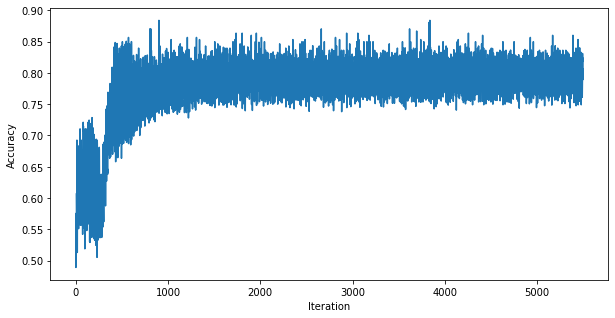

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

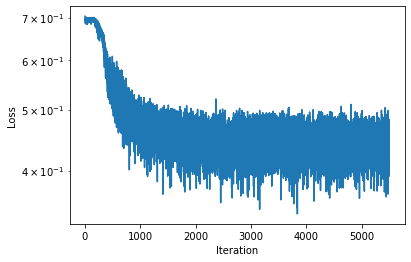

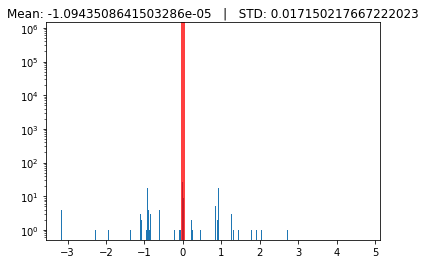

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 8.24390243902439


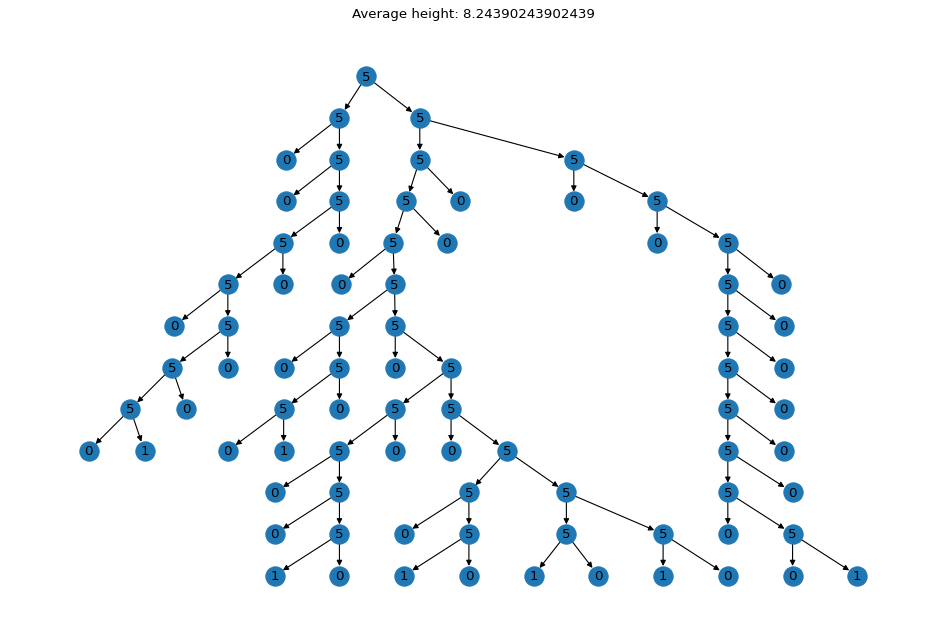

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 41


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
30
============== Pattern 11 ==============
5733
============== Pattern 12 ==============
============== Pattern 13 ==============
4668
============== Pattern 14 ==============
============== Pattern 15 ==============
2648
============== Pattern 16 ==============
1188
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
==